This notebook replicates the second experiment with 2FC-Net on MNIST dataset from our paper "MARS: Masked Automatic Ranks Selection in Tensor Decompositions".

Compression mode: **soft** ($\pi = 10^{-1}$, $\alpha = -1.5$).

**Preliminaries**

In [1]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline
%config InlineBackend.figure_format = 'svg' 

import torch
import numpy as np

import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms

from mars import MARS, MARSLoss, get_MARS_attr, set_MARS_attr
from tensorized_models import TTLinear

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
        
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
seed = 228  # set random seed
torch.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

**Model and hyperparameters definition**

In [4]:
# Compression modes parameters
modes_dict = {
    "soft": dict(pi=1e-1, alpha=-1.5),
    "hard": dict(pi=1e-2, alpha=-1.75),
}

In [5]:
class Net(nn.Module):
    def __init__(self, pi, alpha):
        """
        2FC-Net consists of 2 MARS linear layers with ReLU non-linearity.
        The first layer is 784x625 and is factored into (7, 4, 7, 4)x(5, 5, 5, 5).
        The second layer is 625x10 and is factored into (25, 25)x(5, 2).
        
        Parameters are:
        pi : float
            The value of the prior parameter in Bernoulli masks prior.
        alpha : float
            The value of the phi logits initialization mean.
        """
        super(Net, self).__init__()
        self.input_layer = MARS(
            TTLinear(
                784, 
                625, 
                d=4, 
                tt_rank=20, 
                auto_shapes=False, 
                shape=((7,4,7,4), (5,5,5,5))
            ),
            pi=pi,
            alpha=alpha
        )
        self.output_layer = MARS(
            TTLinear(
                625, 
                10, 
                d=2, 
                tt_rank=20, 
                auto_shapes=False, 
                shape=((25,25), (5,2))
            ),
            pi=pi,
            alpha=alpha
        )

    def forward(self, x):
        x = x.view(-1, 784)
        x = torch.relu(self.input_layer(x))
        return self.output_layer(x)

In [6]:
# Hyperparameters section
# In this experiment, we take enough epochs to guarantee complete convergence.
# One can take fewer but adjust the temperature annealing schedule appropriately.
n_epochs = 300  
batch_size = 128
lr = 1e-2
gamma = 0.99
temp_anneal = lambda t: max(1e-2, gamma * t)

In [7]:
# MNIST Dataset (Images and Labels)
trainset = datasets.MNIST(root='./data/', 
                          train=True, 
                          transform=transforms.ToTensor(),
                          download=True)

testset = datasets.MNIST(root='./data/', 
                         train=False, 
                         transform=transforms.ToTensor())

# Dataset Loader (Input Pipline)
trainloader = torch.utils.data.DataLoader(dataset=trainset, 
                                          batch_size=batch_size, 
                                          shuffle=True)

testloader = torch.utils.data.DataLoader(dataset=testset, 
                                         batch_size=batch_size, 
                                         shuffle=False)

**Functions definition**

In [8]:
def train_model(model_idx, mode="soft", save=True, load=True):
    """
    Train the model or load the trained one.
    
    Parameters are:
        model_idx : int
            Model index to load or save.
        mode : str in {'soft', 'hard'}
            Compression mode.
        save : bool
            Whether to save the trained model.
        load : bool
            Whether to load the trained model.
    """
    model_directory_path = f"./models/MNIST-2FC/{mode}/"
    prefix = str(model_idx)
        
    model_path = model_directory_path + prefix + '-model.pt'
    losses_path = model_directory_path + prefix + '-losses.npy'
    print("Model path: ", model_path)

    if save and not os.path.exists(model_directory_path):
        os.makedirs(model_directory_path)
        
    model = Net(**modes_dict[mode]).to(device)
    
    if load and os.path.isfile(model_path):
        # load trained model parameters from disk
        model.load_state_dict(torch.load(model_path))
        losses = np.load(losses_path)
        print('Loaded model parameters from disk.')
        return model, losses
    
    cross_entropy = nn.CrossEntropyLoss()
    criterion = MARSLoss(model, len(trainset), cross_entropy)
    optimizer = optim.Adam(model.parameters(), lr)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma)

    print("Training...")
    model.train()
    losses = []
    log_step = len(trainloader) // 300 * 100
    
    for epoch in range(n_epochs):
        running_loss = 0.0
        running_cel = 0.0
        losses.append(0.0)

        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses[-1] += loss.item()
            loss.backward()
            optimizer.step()

            # update statistics
            running_loss += loss.item()
            with torch.no_grad():
                cel = cross_entropy(outputs, labels)
            running_cel += cel.item()

            if i % log_step == log_step-1:
                print('[%d, %5d] \t Loss: %.3f \t CEL: %.3f \t T: %.3f' %
                      (epoch + 1, i + 1, 
                       running_loss / log_step, 
                       running_cel / log_step, 
                       get_MARS_attr(model, "temperature")))
                running_loss = 0.0
                running_cel = 0.0
                
        losses[-1] /= i + 1
        
        new_temp = temp_anneal(get_MARS_attr(model, "temperature"))
        set_MARS_attr(model, "temperature", new_temp)

        scheduler.step()

    losses = np.array(losses)
    print('Finished Training.')
    
    if save:
        torch.save(model.state_dict(), model_path)
        np.save(losses_path, losses)
        print('Saved model parameters to disk.')
    
    return model, losses

In [9]:
def eval_model(model):
    "Evaluate a single model on test set."
    model.eval()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            predicted = outputs.argmax(-1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

In [10]:
def eval_ensemble(models):
    "Evaluate the whole ensemble on test set."
    for model in models:
        model.eval()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = torch.stack([model(images) for model in models])
            outputs = torch.softmax(outputs, -1)
            outputs = outputs.mean(0)
                
            predicted = outputs.argmax(-1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

In [11]:
def get_comp_info(model):
    "Plot model masks probabilities, print compression info and return total compression."
    MARS_layers = [l for l in model.modules() if isinstance(l, MARS)]
    
    ranks_list = []
    totals, dofs = [], []

    for l in MARS_layers:
        print("Layer: ", l.tensorized_model)
        phi_logits_list = l.phi_logits_list
        F = l.F
        eval_logits_threshold = l.eval_logits_threshold
        p_threshold = F(torch.tensor(eval_logits_threshold)).item()
        ranks = []

        for m, logits in enumerate(phi_logits_list, 1):
            logits = logits.detach().cpu()
            probs = F(logits).data.numpy()
            
            plt.title(f"Mask {m}")
            plt.bar(np.arange(1, len(probs) + 1), probs)
            plt.xlabel('Rank')
            plt.ylabel(r'$\phi$ value')
            plt.hlines(p_threshold, 0, len(probs) + 1, linestyles='--')
            plt.text(0, p_threshold * 1.05, 'Rounding threshold')
            plt.show()

            rank = (logits > eval_logits_threshold).sum().item()
            print("#nz ranks: {0}/{1}".format(rank, len(logits)))
            ranks.append(rank)

        ranks_list.append(ranks)
        print()
        
        dofs.append(l.tensorized_model.calc_dof(ranks))
        totals.append(l.tensorized_model.total)
        comp = totals[-1] / dofs[-1]
        
        print("Compression:\t%.3f" % comp)
        print(100*"=")

    all_params = sum(p.numel() for p in model.parameters())
    mars_params = sum(logits.numel() for l in MARS_layers for logits in l.phi_logits_list)
    mars_params += sum(l.tensorized_model.calc_dof() for l in MARS_layers)
    other_params = all_params - mars_params
    
    total_comp = (other_params + sum(totals)) / (other_params + sum(dofs))
    print("Total compression:\t%.3f" % total_comp)
    
    return total_comp

**MARS ensemble training**

In [12]:
n_models = 10  # set the number of models in ensemble
mode = "soft"  # set the compression mode
models, losses = [], []

In [13]:
for k in range(1, 11):
    print(f"Model number {k}...")
    model, loss = train_model(k, mode)
    losses.append(loss)
    models.append(model)
    print()
    print(100*'=')
    print()

Model number 1...
Model path:  ./models/MNIST-2FC/soft/1-model.pt
Training...
[1,   100] 	 Loss: 2.303 	 CEL: 2.302 	 T: 0.100
[1,   200] 	 Loss: 2.294 	 CEL: 2.293 	 T: 0.100
[1,   300] 	 Loss: 2.322 	 CEL: 2.321 	 T: 0.100
[1,   400] 	 Loss: 2.279 	 CEL: 2.278 	 T: 0.100
[2,   100] 	 Loss: 2.222 	 CEL: 2.221 	 T: 0.099
[2,   200] 	 Loss: 2.292 	 CEL: 2.292 	 T: 0.099
[2,   300] 	 Loss: 2.219 	 CEL: 2.218 	 T: 0.099
[2,   400] 	 Loss: 2.272 	 CEL: 2.271 	 T: 0.099
[3,   100] 	 Loss: 2.055 	 CEL: 2.054 	 T: 0.098
[3,   200] 	 Loss: 2.010 	 CEL: 2.009 	 T: 0.098
[3,   300] 	 Loss: 2.004 	 CEL: 2.003 	 T: 0.098
[3,   400] 	 Loss: 1.957 	 CEL: 1.956 	 T: 0.098
[4,   100] 	 Loss: 1.831 	 CEL: 1.830 	 T: 0.097
[4,   200] 	 Loss: 1.704 	 CEL: 1.703 	 T: 0.097
[4,   300] 	 Loss: 1.732 	 CEL: 1.731 	 T: 0.097
[4,   400] 	 Loss: 1.594 	 CEL: 1.593 	 T: 0.097
[5,   100] 	 Loss: 1.311 	 CEL: 1.310 	 T: 0.096
[5,   200] 	 Loss: 1.209 	 CEL: 1.208 	 T: 0.096
[5,   300] 	 Loss: 1.051 	 CEL: 1.049 	 

[42,   100] 	 Loss: 0.078 	 CEL: 0.076 	 T: 0.066
[42,   200] 	 Loss: 0.071 	 CEL: 0.070 	 T: 0.066
[42,   300] 	 Loss: 0.072 	 CEL: 0.071 	 T: 0.066
[42,   400] 	 Loss: 0.077 	 CEL: 0.076 	 T: 0.066
[43,   100] 	 Loss: 0.077 	 CEL: 0.076 	 T: 0.066
[43,   200] 	 Loss: 0.067 	 CEL: 0.066 	 T: 0.066
[43,   300] 	 Loss: 0.093 	 CEL: 0.091 	 T: 0.066
[43,   400] 	 Loss: 0.069 	 CEL: 0.068 	 T: 0.066
[44,   100] 	 Loss: 0.061 	 CEL: 0.059 	 T: 0.065
[44,   200] 	 Loss: 0.080 	 CEL: 0.079 	 T: 0.065
[44,   300] 	 Loss: 0.078 	 CEL: 0.077 	 T: 0.065
[44,   400] 	 Loss: 0.068 	 CEL: 0.067 	 T: 0.065
[45,   100] 	 Loss: 0.072 	 CEL: 0.070 	 T: 0.064
[45,   200] 	 Loss: 0.072 	 CEL: 0.070 	 T: 0.064
[45,   300] 	 Loss: 0.068 	 CEL: 0.067 	 T: 0.064
[45,   400] 	 Loss: 0.078 	 CEL: 0.077 	 T: 0.064
[46,   100] 	 Loss: 0.081 	 CEL: 0.080 	 T: 0.064
[46,   200] 	 Loss: 0.064 	 CEL: 0.063 	 T: 0.064
[46,   300] 	 Loss: 0.079 	 CEL: 0.078 	 T: 0.064
[46,   400] 	 Loss: 0.076 	 CEL: 0.075 	 T: 0.064


[83,   100] 	 Loss: 0.040 	 CEL: 0.039 	 T: 0.044
[83,   200] 	 Loss: 0.036 	 CEL: 0.035 	 T: 0.044
[83,   300] 	 Loss: 0.045 	 CEL: 0.044 	 T: 0.044
[83,   400] 	 Loss: 0.050 	 CEL: 0.048 	 T: 0.044
[84,   100] 	 Loss: 0.044 	 CEL: 0.043 	 T: 0.043
[84,   200] 	 Loss: 0.039 	 CEL: 0.038 	 T: 0.043
[84,   300] 	 Loss: 0.041 	 CEL: 0.040 	 T: 0.043
[84,   400] 	 Loss: 0.043 	 CEL: 0.041 	 T: 0.043
[85,   100] 	 Loss: 0.036 	 CEL: 0.035 	 T: 0.043
[85,   200] 	 Loss: 0.045 	 CEL: 0.044 	 T: 0.043
[85,   300] 	 Loss: 0.043 	 CEL: 0.042 	 T: 0.043
[85,   400] 	 Loss: 0.061 	 CEL: 0.060 	 T: 0.043
[86,   100] 	 Loss: 0.035 	 CEL: 0.034 	 T: 0.043
[86,   200] 	 Loss: 0.048 	 CEL: 0.047 	 T: 0.043
[86,   300] 	 Loss: 0.043 	 CEL: 0.042 	 T: 0.043
[86,   400] 	 Loss: 0.039 	 CEL: 0.038 	 T: 0.043
[87,   100] 	 Loss: 0.032 	 CEL: 0.031 	 T: 0.042
[87,   200] 	 Loss: 0.045 	 CEL: 0.044 	 T: 0.042
[87,   300] 	 Loss: 0.045 	 CEL: 0.044 	 T: 0.042
[87,   400] 	 Loss: 0.054 	 CEL: 0.053 	 T: 0.042


[123,   300] 	 Loss: 0.026 	 CEL: 0.025 	 T: 0.029
[123,   400] 	 Loss: 0.024 	 CEL: 0.023 	 T: 0.029
[124,   100] 	 Loss: 0.029 	 CEL: 0.028 	 T: 0.029
[124,   200] 	 Loss: 0.025 	 CEL: 0.024 	 T: 0.029
[124,   300] 	 Loss: 0.026 	 CEL: 0.025 	 T: 0.029
[124,   400] 	 Loss: 0.035 	 CEL: 0.034 	 T: 0.029
[125,   100] 	 Loss: 0.028 	 CEL: 0.027 	 T: 0.029
[125,   200] 	 Loss: 0.023 	 CEL: 0.022 	 T: 0.029
[125,   300] 	 Loss: 0.034 	 CEL: 0.033 	 T: 0.029
[125,   400] 	 Loss: 0.027 	 CEL: 0.026 	 T: 0.029
[126,   100] 	 Loss: 0.023 	 CEL: 0.022 	 T: 0.028
[126,   200] 	 Loss: 0.027 	 CEL: 0.025 	 T: 0.028
[126,   300] 	 Loss: 0.026 	 CEL: 0.025 	 T: 0.028
[126,   400] 	 Loss: 0.029 	 CEL: 0.028 	 T: 0.028
[127,   100] 	 Loss: 0.021 	 CEL: 0.020 	 T: 0.028
[127,   200] 	 Loss: 0.030 	 CEL: 0.029 	 T: 0.028
[127,   300] 	 Loss: 0.030 	 CEL: 0.029 	 T: 0.028
[127,   400] 	 Loss: 0.028 	 CEL: 0.027 	 T: 0.028
[128,   100] 	 Loss: 0.033 	 CEL: 0.032 	 T: 0.028
[128,   200] 	 Loss: 0.033 	 CE

[163,   400] 	 Loss: 0.017 	 CEL: 0.016 	 T: 0.020
[164,   100] 	 Loss: 0.018 	 CEL: 0.017 	 T: 0.019
[164,   200] 	 Loss: 0.011 	 CEL: 0.010 	 T: 0.019
[164,   300] 	 Loss: 0.017 	 CEL: 0.016 	 T: 0.019
[164,   400] 	 Loss: 0.029 	 CEL: 0.028 	 T: 0.019
[165,   100] 	 Loss: 0.011 	 CEL: 0.010 	 T: 0.019
[165,   200] 	 Loss: 0.012 	 CEL: 0.011 	 T: 0.019
[165,   300] 	 Loss: 0.013 	 CEL: 0.012 	 T: 0.019
[165,   400] 	 Loss: 0.019 	 CEL: 0.018 	 T: 0.019
[166,   100] 	 Loss: 0.017 	 CEL: 0.016 	 T: 0.019
[166,   200] 	 Loss: 0.021 	 CEL: 0.019 	 T: 0.019
[166,   300] 	 Loss: 0.024 	 CEL: 0.023 	 T: 0.019
[166,   400] 	 Loss: 0.024 	 CEL: 0.023 	 T: 0.019
[167,   100] 	 Loss: 0.021 	 CEL: 0.019 	 T: 0.019
[167,   200] 	 Loss: 0.014 	 CEL: 0.013 	 T: 0.019
[167,   300] 	 Loss: 0.014 	 CEL: 0.013 	 T: 0.019
[167,   400] 	 Loss: 0.016 	 CEL: 0.015 	 T: 0.019
[168,   100] 	 Loss: 0.014 	 CEL: 0.013 	 T: 0.019
[168,   200] 	 Loss: 0.028 	 CEL: 0.026 	 T: 0.019
[168,   300] 	 Loss: 0.017 	 CE

[204,   100] 	 Loss: 0.009 	 CEL: 0.008 	 T: 0.013
[204,   200] 	 Loss: 0.011 	 CEL: 0.010 	 T: 0.013
[204,   300] 	 Loss: 0.016 	 CEL: 0.015 	 T: 0.013
[204,   400] 	 Loss: 0.014 	 CEL: 0.013 	 T: 0.013
[205,   100] 	 Loss: 0.014 	 CEL: 0.013 	 T: 0.013
[205,   200] 	 Loss: 0.015 	 CEL: 0.014 	 T: 0.013
[205,   300] 	 Loss: 0.014 	 CEL: 0.013 	 T: 0.013
[205,   400] 	 Loss: 0.019 	 CEL: 0.018 	 T: 0.013
[206,   100] 	 Loss: 0.014 	 CEL: 0.012 	 T: 0.013
[206,   200] 	 Loss: 0.011 	 CEL: 0.010 	 T: 0.013
[206,   300] 	 Loss: 0.012 	 CEL: 0.011 	 T: 0.013
[206,   400] 	 Loss: 0.013 	 CEL: 0.012 	 T: 0.013
[207,   100] 	 Loss: 0.018 	 CEL: 0.017 	 T: 0.013
[207,   200] 	 Loss: 0.011 	 CEL: 0.010 	 T: 0.013
[207,   300] 	 Loss: 0.014 	 CEL: 0.013 	 T: 0.013
[207,   400] 	 Loss: 0.011 	 CEL: 0.010 	 T: 0.013
[208,   100] 	 Loss: 0.012 	 CEL: 0.010 	 T: 0.012
[208,   200] 	 Loss: 0.019 	 CEL: 0.018 	 T: 0.012
[208,   300] 	 Loss: 0.012 	 CEL: 0.011 	 T: 0.012
[208,   400] 	 Loss: 0.020 	 CE

[244,   200] 	 Loss: 0.040 	 CEL: 0.039 	 T: 0.010
[244,   300] 	 Loss: 0.026 	 CEL: 0.025 	 T: 0.010
[244,   400] 	 Loss: 0.029 	 CEL: 0.028 	 T: 0.010
[245,   100] 	 Loss: 0.028 	 CEL: 0.027 	 T: 0.010
[245,   200] 	 Loss: 0.026 	 CEL: 0.025 	 T: 0.010
[245,   300] 	 Loss: 0.028 	 CEL: 0.027 	 T: 0.010
[245,   400] 	 Loss: 0.026 	 CEL: 0.025 	 T: 0.010
[246,   100] 	 Loss: 0.018 	 CEL: 0.017 	 T: 0.010
[246,   200] 	 Loss: 0.024 	 CEL: 0.023 	 T: 0.010
[246,   300] 	 Loss: 0.020 	 CEL: 0.019 	 T: 0.010
[246,   400] 	 Loss: 0.020 	 CEL: 0.019 	 T: 0.010
[247,   100] 	 Loss: 0.028 	 CEL: 0.027 	 T: 0.010
[247,   200] 	 Loss: 0.028 	 CEL: 0.027 	 T: 0.010
[247,   300] 	 Loss: 0.034 	 CEL: 0.033 	 T: 0.010
[247,   400] 	 Loss: 0.025 	 CEL: 0.024 	 T: 0.010
[248,   100] 	 Loss: 0.019 	 CEL: 0.018 	 T: 0.010
[248,   200] 	 Loss: 0.028 	 CEL: 0.027 	 T: 0.010
[248,   300] 	 Loss: 0.031 	 CEL: 0.030 	 T: 0.010
[248,   400] 	 Loss: 0.026 	 CEL: 0.025 	 T: 0.010
[249,   100] 	 Loss: 0.029 	 CE

[284,   300] 	 Loss: 0.022 	 CEL: 0.021 	 T: 0.010
[284,   400] 	 Loss: 0.020 	 CEL: 0.019 	 T: 0.010
[285,   100] 	 Loss: 0.017 	 CEL: 0.016 	 T: 0.010
[285,   200] 	 Loss: 0.021 	 CEL: 0.020 	 T: 0.010
[285,   300] 	 Loss: 0.015 	 CEL: 0.014 	 T: 0.010
[285,   400] 	 Loss: 0.018 	 CEL: 0.017 	 T: 0.010
[286,   100] 	 Loss: 0.023 	 CEL: 0.022 	 T: 0.010
[286,   200] 	 Loss: 0.028 	 CEL: 0.027 	 T: 0.010
[286,   300] 	 Loss: 0.028 	 CEL: 0.027 	 T: 0.010
[286,   400] 	 Loss: 0.020 	 CEL: 0.019 	 T: 0.010
[287,   100] 	 Loss: 0.024 	 CEL: 0.023 	 T: 0.010
[287,   200] 	 Loss: 0.024 	 CEL: 0.023 	 T: 0.010
[287,   300] 	 Loss: 0.018 	 CEL: 0.017 	 T: 0.010
[287,   400] 	 Loss: 0.021 	 CEL: 0.020 	 T: 0.010
[288,   100] 	 Loss: 0.019 	 CEL: 0.018 	 T: 0.010
[288,   200] 	 Loss: 0.020 	 CEL: 0.019 	 T: 0.010
[288,   300] 	 Loss: 0.018 	 CEL: 0.017 	 T: 0.010
[288,   400] 	 Loss: 0.021 	 CEL: 0.020 	 T: 0.010
[289,   100] 	 Loss: 0.021 	 CEL: 0.020 	 T: 0.010
[289,   200] 	 Loss: 0.015 	 CE

[24,   200] 	 Loss: 0.131 	 CEL: 0.129 	 T: 0.079
[24,   300] 	 Loss: 0.134 	 CEL: 0.133 	 T: 0.079
[24,   400] 	 Loss: 0.120 	 CEL: 0.119 	 T: 0.079
[25,   100] 	 Loss: 0.105 	 CEL: 0.103 	 T: 0.079
[25,   200] 	 Loss: 0.125 	 CEL: 0.124 	 T: 0.079
[25,   300] 	 Loss: 0.138 	 CEL: 0.136 	 T: 0.079
[25,   400] 	 Loss: 0.120 	 CEL: 0.118 	 T: 0.079
[26,   100] 	 Loss: 0.109 	 CEL: 0.108 	 T: 0.078
[26,   200] 	 Loss: 0.112 	 CEL: 0.110 	 T: 0.078
[26,   300] 	 Loss: 0.119 	 CEL: 0.117 	 T: 0.078
[26,   400] 	 Loss: 0.114 	 CEL: 0.112 	 T: 0.078
[27,   100] 	 Loss: 0.093 	 CEL: 0.092 	 T: 0.077
[27,   200] 	 Loss: 0.107 	 CEL: 0.106 	 T: 0.077
[27,   300] 	 Loss: 0.110 	 CEL: 0.109 	 T: 0.077
[27,   400] 	 Loss: 0.110 	 CEL: 0.109 	 T: 0.077
[28,   100] 	 Loss: 0.099 	 CEL: 0.098 	 T: 0.076
[28,   200] 	 Loss: 0.094 	 CEL: 0.092 	 T: 0.076
[28,   300] 	 Loss: 0.107 	 CEL: 0.105 	 T: 0.076
[28,   400] 	 Loss: 0.105 	 CEL: 0.104 	 T: 0.076
[29,   100] 	 Loss: 0.110 	 CEL: 0.108 	 T: 0.075


[65,   200] 	 Loss: 0.044 	 CEL: 0.043 	 T: 0.053
[65,   300] 	 Loss: 0.057 	 CEL: 0.056 	 T: 0.053
[65,   400] 	 Loss: 0.058 	 CEL: 0.057 	 T: 0.053
[66,   100] 	 Loss: 0.047 	 CEL: 0.046 	 T: 0.052
[66,   200] 	 Loss: 0.063 	 CEL: 0.062 	 T: 0.052
[66,   300] 	 Loss: 0.052 	 CEL: 0.051 	 T: 0.052
[66,   400] 	 Loss: 0.058 	 CEL: 0.057 	 T: 0.052
[67,   100] 	 Loss: 0.054 	 CEL: 0.053 	 T: 0.052
[67,   200] 	 Loss: 0.050 	 CEL: 0.049 	 T: 0.052
[67,   300] 	 Loss: 0.055 	 CEL: 0.054 	 T: 0.052
[67,   400] 	 Loss: 0.061 	 CEL: 0.059 	 T: 0.052
[68,   100] 	 Loss: 0.044 	 CEL: 0.043 	 T: 0.051
[68,   200] 	 Loss: 0.043 	 CEL: 0.042 	 T: 0.051
[68,   300] 	 Loss: 0.063 	 CEL: 0.062 	 T: 0.051
[68,   400] 	 Loss: 0.060 	 CEL: 0.059 	 T: 0.051
[69,   100] 	 Loss: 0.052 	 CEL: 0.051 	 T: 0.050
[69,   200] 	 Loss: 0.046 	 CEL: 0.045 	 T: 0.050
[69,   300] 	 Loss: 0.051 	 CEL: 0.050 	 T: 0.050
[69,   400] 	 Loss: 0.062 	 CEL: 0.061 	 T: 0.050
[70,   100] 	 Loss: 0.041 	 CEL: 0.040 	 T: 0.050


[106,   200] 	 Loss: 0.034 	 CEL: 0.033 	 T: 0.035
[106,   300] 	 Loss: 0.037 	 CEL: 0.036 	 T: 0.035
[106,   400] 	 Loss: 0.041 	 CEL: 0.040 	 T: 0.035
[107,   100] 	 Loss: 0.027 	 CEL: 0.026 	 T: 0.034
[107,   200] 	 Loss: 0.029 	 CEL: 0.028 	 T: 0.034
[107,   300] 	 Loss: 0.039 	 CEL: 0.038 	 T: 0.034
[107,   400] 	 Loss: 0.029 	 CEL: 0.028 	 T: 0.034
[108,   100] 	 Loss: 0.031 	 CEL: 0.030 	 T: 0.034
[108,   200] 	 Loss: 0.029 	 CEL: 0.028 	 T: 0.034
[108,   300] 	 Loss: 0.035 	 CEL: 0.034 	 T: 0.034
[108,   400] 	 Loss: 0.048 	 CEL: 0.047 	 T: 0.034
[109,   100] 	 Loss: 0.024 	 CEL: 0.023 	 T: 0.034
[109,   200] 	 Loss: 0.033 	 CEL: 0.032 	 T: 0.034
[109,   300] 	 Loss: 0.034 	 CEL: 0.033 	 T: 0.034
[109,   400] 	 Loss: 0.038 	 CEL: 0.037 	 T: 0.034
[110,   100] 	 Loss: 0.024 	 CEL: 0.023 	 T: 0.033
[110,   200] 	 Loss: 0.027 	 CEL: 0.026 	 T: 0.033
[110,   300] 	 Loss: 0.035 	 CEL: 0.034 	 T: 0.033
[110,   400] 	 Loss: 0.038 	 CEL: 0.037 	 T: 0.033
[111,   100] 	 Loss: 0.025 	 CE

[146,   300] 	 Loss: 0.026 	 CEL: 0.025 	 T: 0.023
[146,   400] 	 Loss: 0.034 	 CEL: 0.033 	 T: 0.023
[147,   100] 	 Loss: 0.027 	 CEL: 0.026 	 T: 0.023
[147,   200] 	 Loss: 0.021 	 CEL: 0.020 	 T: 0.023
[147,   300] 	 Loss: 0.027 	 CEL: 0.026 	 T: 0.023
[147,   400] 	 Loss: 0.024 	 CEL: 0.023 	 T: 0.023
[148,   100] 	 Loss: 0.020 	 CEL: 0.019 	 T: 0.023
[148,   200] 	 Loss: 0.017 	 CEL: 0.016 	 T: 0.023
[148,   300] 	 Loss: 0.018 	 CEL: 0.017 	 T: 0.023
[148,   400] 	 Loss: 0.035 	 CEL: 0.034 	 T: 0.023
[149,   100] 	 Loss: 0.026 	 CEL: 0.025 	 T: 0.023
[149,   200] 	 Loss: 0.024 	 CEL: 0.023 	 T: 0.023
[149,   300] 	 Loss: 0.021 	 CEL: 0.020 	 T: 0.023
[149,   400] 	 Loss: 0.028 	 CEL: 0.027 	 T: 0.023
[150,   100] 	 Loss: 0.019 	 CEL: 0.018 	 T: 0.022
[150,   200] 	 Loss: 0.019 	 CEL: 0.018 	 T: 0.022
[150,   300] 	 Loss: 0.030 	 CEL: 0.029 	 T: 0.022
[150,   400] 	 Loss: 0.025 	 CEL: 0.024 	 T: 0.022
[151,   100] 	 Loss: 0.015 	 CEL: 0.014 	 T: 0.022
[151,   200] 	 Loss: 0.024 	 CE

[186,   400] 	 Loss: 0.022 	 CEL: 0.021 	 T: 0.016
[187,   100] 	 Loss: 0.020 	 CEL: 0.019 	 T: 0.015
[187,   200] 	 Loss: 0.015 	 CEL: 0.014 	 T: 0.015
[187,   300] 	 Loss: 0.025 	 CEL: 0.024 	 T: 0.015
[187,   400] 	 Loss: 0.015 	 CEL: 0.014 	 T: 0.015
[188,   100] 	 Loss: 0.014 	 CEL: 0.013 	 T: 0.015
[188,   200] 	 Loss: 0.022 	 CEL: 0.021 	 T: 0.015
[188,   300] 	 Loss: 0.015 	 CEL: 0.014 	 T: 0.015
[188,   400] 	 Loss: 0.026 	 CEL: 0.025 	 T: 0.015
[189,   100] 	 Loss: 0.013 	 CEL: 0.012 	 T: 0.015
[189,   200] 	 Loss: 0.018 	 CEL: 0.017 	 T: 0.015
[189,   300] 	 Loss: 0.014 	 CEL: 0.013 	 T: 0.015
[189,   400] 	 Loss: 0.017 	 CEL: 0.016 	 T: 0.015
[190,   100] 	 Loss: 0.016 	 CEL: 0.015 	 T: 0.015
[190,   200] 	 Loss: 0.022 	 CEL: 0.021 	 T: 0.015
[190,   300] 	 Loss: 0.015 	 CEL: 0.014 	 T: 0.015
[190,   400] 	 Loss: 0.024 	 CEL: 0.023 	 T: 0.015
[191,   100] 	 Loss: 0.013 	 CEL: 0.012 	 T: 0.015
[191,   200] 	 Loss: 0.012 	 CEL: 0.011 	 T: 0.015
[191,   300] 	 Loss: 0.016 	 CE

[227,   100] 	 Loss: 0.017 	 CEL: 0.016 	 T: 0.010
[227,   200] 	 Loss: 0.020 	 CEL: 0.019 	 T: 0.010
[227,   300] 	 Loss: 0.020 	 CEL: 0.019 	 T: 0.010
[227,   400] 	 Loss: 0.016 	 CEL: 0.015 	 T: 0.010
[228,   100] 	 Loss: 0.015 	 CEL: 0.014 	 T: 0.010
[228,   200] 	 Loss: 0.026 	 CEL: 0.025 	 T: 0.010
[228,   300] 	 Loss: 0.031 	 CEL: 0.030 	 T: 0.010
[228,   400] 	 Loss: 0.020 	 CEL: 0.019 	 T: 0.010
[229,   100] 	 Loss: 0.022 	 CEL: 0.021 	 T: 0.010
[229,   200] 	 Loss: 0.021 	 CEL: 0.020 	 T: 0.010
[229,   300] 	 Loss: 0.014 	 CEL: 0.013 	 T: 0.010
[229,   400] 	 Loss: 0.019 	 CEL: 0.018 	 T: 0.010
[230,   100] 	 Loss: 0.024 	 CEL: 0.023 	 T: 0.010
[230,   200] 	 Loss: 0.017 	 CEL: 0.016 	 T: 0.010
[230,   300] 	 Loss: 0.031 	 CEL: 0.030 	 T: 0.010
[230,   400] 	 Loss: 0.020 	 CEL: 0.019 	 T: 0.010
[231,   100] 	 Loss: 0.015 	 CEL: 0.014 	 T: 0.010
[231,   200] 	 Loss: 0.022 	 CEL: 0.021 	 T: 0.010
[231,   300] 	 Loss: 0.022 	 CEL: 0.021 	 T: 0.010
[231,   400] 	 Loss: 0.017 	 CE

[267,   200] 	 Loss: 0.016 	 CEL: 0.015 	 T: 0.010
[267,   300] 	 Loss: 0.022 	 CEL: 0.021 	 T: 0.010
[267,   400] 	 Loss: 0.022 	 CEL: 0.021 	 T: 0.010
[268,   100] 	 Loss: 0.018 	 CEL: 0.017 	 T: 0.010
[268,   200] 	 Loss: 0.016 	 CEL: 0.015 	 T: 0.010
[268,   300] 	 Loss: 0.018 	 CEL: 0.017 	 T: 0.010
[268,   400] 	 Loss: 0.014 	 CEL: 0.013 	 T: 0.010
[269,   100] 	 Loss: 0.025 	 CEL: 0.024 	 T: 0.010
[269,   200] 	 Loss: 0.014 	 CEL: 0.013 	 T: 0.010
[269,   300] 	 Loss: 0.025 	 CEL: 0.024 	 T: 0.010
[269,   400] 	 Loss: 0.016 	 CEL: 0.015 	 T: 0.010
[270,   100] 	 Loss: 0.018 	 CEL: 0.017 	 T: 0.010
[270,   200] 	 Loss: 0.023 	 CEL: 0.022 	 T: 0.010
[270,   300] 	 Loss: 0.016 	 CEL: 0.015 	 T: 0.010
[270,   400] 	 Loss: 0.022 	 CEL: 0.021 	 T: 0.010
[271,   100] 	 Loss: 0.024 	 CEL: 0.024 	 T: 0.010
[271,   200] 	 Loss: 0.013 	 CEL: 0.012 	 T: 0.010
[271,   300] 	 Loss: 0.015 	 CEL: 0.014 	 T: 0.010
[271,   400] 	 Loss: 0.014 	 CEL: 0.013 	 T: 0.010
[272,   100] 	 Loss: 0.026 	 CE

[6,   300] 	 Loss: 0.672 	 CEL: 0.671 	 T: 0.095
[6,   400] 	 Loss: 0.622 	 CEL: 0.621 	 T: 0.095
[7,   100] 	 Loss: 0.585 	 CEL: 0.584 	 T: 0.094
[7,   200] 	 Loss: 0.550 	 CEL: 0.549 	 T: 0.094
[7,   300] 	 Loss: 0.517 	 CEL: 0.515 	 T: 0.094
[7,   400] 	 Loss: 0.487 	 CEL: 0.486 	 T: 0.094
[8,   100] 	 Loss: 0.412 	 CEL: 0.411 	 T: 0.093
[8,   200] 	 Loss: 0.420 	 CEL: 0.418 	 T: 0.093
[8,   300] 	 Loss: 0.397 	 CEL: 0.396 	 T: 0.093
[8,   400] 	 Loss: 0.403 	 CEL: 0.401 	 T: 0.093
[9,   100] 	 Loss: 0.369 	 CEL: 0.368 	 T: 0.092
[9,   200] 	 Loss: 0.381 	 CEL: 0.380 	 T: 0.092
[9,   300] 	 Loss: 0.348 	 CEL: 0.347 	 T: 0.092
[9,   400] 	 Loss: 0.354 	 CEL: 0.352 	 T: 0.092
[10,   100] 	 Loss: 0.302 	 CEL: 0.301 	 T: 0.091
[10,   200] 	 Loss: 0.316 	 CEL: 0.314 	 T: 0.091
[10,   300] 	 Loss: 0.307 	 CEL: 0.305 	 T: 0.091
[10,   400] 	 Loss: 0.290 	 CEL: 0.289 	 T: 0.091
[11,   100] 	 Loss: 0.262 	 CEL: 0.261 	 T: 0.090
[11,   200] 	 Loss: 0.262 	 CEL: 0.260 	 T: 0.090
[11,   300] 	 

[47,   400] 	 Loss: 0.067 	 CEL: 0.066 	 T: 0.063
[48,   100] 	 Loss: 0.057 	 CEL: 0.056 	 T: 0.062
[48,   200] 	 Loss: 0.064 	 CEL: 0.062 	 T: 0.062
[48,   300] 	 Loss: 0.061 	 CEL: 0.060 	 T: 0.062
[48,   400] 	 Loss: 0.070 	 CEL: 0.068 	 T: 0.062
[49,   100] 	 Loss: 0.059 	 CEL: 0.057 	 T: 0.062
[49,   200] 	 Loss: 0.066 	 CEL: 0.065 	 T: 0.062
[49,   300] 	 Loss: 0.061 	 CEL: 0.060 	 T: 0.062
[49,   400] 	 Loss: 0.065 	 CEL: 0.064 	 T: 0.062
[50,   100] 	 Loss: 0.054 	 CEL: 0.053 	 T: 0.061
[50,   200] 	 Loss: 0.084 	 CEL: 0.083 	 T: 0.061
[50,   300] 	 Loss: 0.064 	 CEL: 0.063 	 T: 0.061
[50,   400] 	 Loss: 0.061 	 CEL: 0.060 	 T: 0.061
[51,   100] 	 Loss: 0.058 	 CEL: 0.057 	 T: 0.061
[51,   200] 	 Loss: 0.066 	 CEL: 0.064 	 T: 0.061
[51,   300] 	 Loss: 0.061 	 CEL: 0.060 	 T: 0.061
[51,   400] 	 Loss: 0.059 	 CEL: 0.058 	 T: 0.061
[52,   100] 	 Loss: 0.053 	 CEL: 0.052 	 T: 0.060
[52,   200] 	 Loss: 0.066 	 CEL: 0.065 	 T: 0.060
[52,   300] 	 Loss: 0.063 	 CEL: 0.062 	 T: 0.060


[88,   400] 	 Loss: 0.043 	 CEL: 0.042 	 T: 0.042
[89,   100] 	 Loss: 0.031 	 CEL: 0.030 	 T: 0.041
[89,   200] 	 Loss: 0.037 	 CEL: 0.036 	 T: 0.041
[89,   300] 	 Loss: 0.032 	 CEL: 0.031 	 T: 0.041
[89,   400] 	 Loss: 0.044 	 CEL: 0.043 	 T: 0.041
[90,   100] 	 Loss: 0.031 	 CEL: 0.030 	 T: 0.041
[90,   200] 	 Loss: 0.033 	 CEL: 0.032 	 T: 0.041
[90,   300] 	 Loss: 0.041 	 CEL: 0.040 	 T: 0.041
[90,   400] 	 Loss: 0.045 	 CEL: 0.044 	 T: 0.041
[91,   100] 	 Loss: 0.037 	 CEL: 0.036 	 T: 0.040
[91,   200] 	 Loss: 0.047 	 CEL: 0.046 	 T: 0.040
[91,   300] 	 Loss: 0.035 	 CEL: 0.033 	 T: 0.040
[91,   400] 	 Loss: 0.045 	 CEL: 0.043 	 T: 0.040
[92,   100] 	 Loss: 0.034 	 CEL: 0.033 	 T: 0.040
[92,   200] 	 Loss: 0.030 	 CEL: 0.029 	 T: 0.040
[92,   300] 	 Loss: 0.038 	 CEL: 0.036 	 T: 0.040
[92,   400] 	 Loss: 0.035 	 CEL: 0.034 	 T: 0.040
[93,   100] 	 Loss: 0.032 	 CEL: 0.030 	 T: 0.040
[93,   200] 	 Loss: 0.045 	 CEL: 0.044 	 T: 0.040
[93,   300] 	 Loss: 0.038 	 CEL: 0.037 	 T: 0.040


[129,   200] 	 Loss: 0.023 	 CEL: 0.022 	 T: 0.028
[129,   300] 	 Loss: 0.029 	 CEL: 0.027 	 T: 0.028
[129,   400] 	 Loss: 0.028 	 CEL: 0.027 	 T: 0.028
[130,   100] 	 Loss: 0.027 	 CEL: 0.026 	 T: 0.027
[130,   200] 	 Loss: 0.029 	 CEL: 0.028 	 T: 0.027
[130,   300] 	 Loss: 0.023 	 CEL: 0.022 	 T: 0.027
[130,   400] 	 Loss: 0.019 	 CEL: 0.018 	 T: 0.027
[131,   100] 	 Loss: 0.020 	 CEL: 0.019 	 T: 0.027
[131,   200] 	 Loss: 0.021 	 CEL: 0.020 	 T: 0.027
[131,   300] 	 Loss: 0.024 	 CEL: 0.023 	 T: 0.027
[131,   400] 	 Loss: 0.031 	 CEL: 0.030 	 T: 0.027
[132,   100] 	 Loss: 0.027 	 CEL: 0.026 	 T: 0.027
[132,   200] 	 Loss: 0.023 	 CEL: 0.022 	 T: 0.027
[132,   300] 	 Loss: 0.026 	 CEL: 0.024 	 T: 0.027
[132,   400] 	 Loss: 0.030 	 CEL: 0.029 	 T: 0.027
[133,   100] 	 Loss: 0.021 	 CEL: 0.020 	 T: 0.027
[133,   200] 	 Loss: 0.033 	 CEL: 0.032 	 T: 0.027
[133,   300] 	 Loss: 0.027 	 CEL: 0.026 	 T: 0.027
[133,   400] 	 Loss: 0.035 	 CEL: 0.034 	 T: 0.027
[134,   100] 	 Loss: 0.023 	 CE

[169,   300] 	 Loss: 0.018 	 CEL: 0.017 	 T: 0.018
[169,   400] 	 Loss: 0.016 	 CEL: 0.015 	 T: 0.018
[170,   100] 	 Loss: 0.028 	 CEL: 0.027 	 T: 0.018
[170,   200] 	 Loss: 0.013 	 CEL: 0.012 	 T: 0.018
[170,   300] 	 Loss: 0.028 	 CEL: 0.026 	 T: 0.018
[170,   400] 	 Loss: 0.023 	 CEL: 0.022 	 T: 0.018
[171,   100] 	 Loss: 0.017 	 CEL: 0.016 	 T: 0.018
[171,   200] 	 Loss: 0.015 	 CEL: 0.014 	 T: 0.018
[171,   300] 	 Loss: 0.017 	 CEL: 0.015 	 T: 0.018
[171,   400] 	 Loss: 0.016 	 CEL: 0.015 	 T: 0.018
[172,   100] 	 Loss: 0.013 	 CEL: 0.012 	 T: 0.018
[172,   200] 	 Loss: 0.017 	 CEL: 0.016 	 T: 0.018
[172,   300] 	 Loss: 0.014 	 CEL: 0.013 	 T: 0.018
[172,   400] 	 Loss: 0.024 	 CEL: 0.023 	 T: 0.018
[173,   100] 	 Loss: 0.020 	 CEL: 0.019 	 T: 0.018
[173,   200] 	 Loss: 0.037 	 CEL: 0.036 	 T: 0.018
[173,   300] 	 Loss: 0.033 	 CEL: 0.032 	 T: 0.018
[173,   400] 	 Loss: 0.029 	 CEL: 0.028 	 T: 0.018
[174,   100] 	 Loss: 0.024 	 CEL: 0.023 	 T: 0.018
[174,   200] 	 Loss: 0.029 	 CE

[209,   400] 	 Loss: 0.023 	 CEL: 0.022 	 T: 0.012
[210,   100] 	 Loss: 0.023 	 CEL: 0.022 	 T: 0.012
[210,   200] 	 Loss: 0.018 	 CEL: 0.017 	 T: 0.012
[210,   300] 	 Loss: 0.018 	 CEL: 0.017 	 T: 0.012
[210,   400] 	 Loss: 0.017 	 CEL: 0.016 	 T: 0.012
[211,   100] 	 Loss: 0.018 	 CEL: 0.017 	 T: 0.012
[211,   200] 	 Loss: 0.020 	 CEL: 0.019 	 T: 0.012
[211,   300] 	 Loss: 0.020 	 CEL: 0.019 	 T: 0.012
[211,   400] 	 Loss: 0.014 	 CEL: 0.013 	 T: 0.012
[212,   100] 	 Loss: 0.013 	 CEL: 0.012 	 T: 0.012
[212,   200] 	 Loss: 0.019 	 CEL: 0.017 	 T: 0.012
[212,   300] 	 Loss: 0.019 	 CEL: 0.018 	 T: 0.012
[212,   400] 	 Loss: 0.024 	 CEL: 0.023 	 T: 0.012
[213,   100] 	 Loss: 0.009 	 CEL: 0.008 	 T: 0.012
[213,   200] 	 Loss: 0.017 	 CEL: 0.016 	 T: 0.012
[213,   300] 	 Loss: 0.020 	 CEL: 0.019 	 T: 0.012
[213,   400] 	 Loss: 0.013 	 CEL: 0.012 	 T: 0.012
[214,   100] 	 Loss: 0.018 	 CEL: 0.017 	 T: 0.012
[214,   200] 	 Loss: 0.013 	 CEL: 0.012 	 T: 0.012
[214,   300] 	 Loss: 0.017 	 CE

[250,   100] 	 Loss: 0.025 	 CEL: 0.024 	 T: 0.010
[250,   200] 	 Loss: 0.027 	 CEL: 0.026 	 T: 0.010
[250,   300] 	 Loss: 0.027 	 CEL: 0.026 	 T: 0.010
[250,   400] 	 Loss: 0.030 	 CEL: 0.029 	 T: 0.010
[251,   100] 	 Loss: 0.032 	 CEL: 0.031 	 T: 0.010
[251,   200] 	 Loss: 0.037 	 CEL: 0.036 	 T: 0.010
[251,   300] 	 Loss: 0.040 	 CEL: 0.039 	 T: 0.010
[251,   400] 	 Loss: 0.039 	 CEL: 0.038 	 T: 0.010
[252,   100] 	 Loss: 0.024 	 CEL: 0.023 	 T: 0.010
[252,   200] 	 Loss: 0.027 	 CEL: 0.026 	 T: 0.010
[252,   300] 	 Loss: 0.022 	 CEL: 0.021 	 T: 0.010
[252,   400] 	 Loss: 0.022 	 CEL: 0.021 	 T: 0.010
[253,   100] 	 Loss: 0.031 	 CEL: 0.030 	 T: 0.010
[253,   200] 	 Loss: 0.028 	 CEL: 0.027 	 T: 0.010
[253,   300] 	 Loss: 0.030 	 CEL: 0.029 	 T: 0.010
[253,   400] 	 Loss: 0.027 	 CEL: 0.026 	 T: 0.010
[254,   100] 	 Loss: 0.021 	 CEL: 0.020 	 T: 0.010
[254,   200] 	 Loss: 0.030 	 CEL: 0.029 	 T: 0.010
[254,   300] 	 Loss: 0.031 	 CEL: 0.030 	 T: 0.010
[254,   400] 	 Loss: 0.026 	 CE

[290,   200] 	 Loss: 0.026 	 CEL: 0.025 	 T: 0.010
[290,   300] 	 Loss: 0.021 	 CEL: 0.020 	 T: 0.010
[290,   400] 	 Loss: 0.017 	 CEL: 0.016 	 T: 0.010
[291,   100] 	 Loss: 0.016 	 CEL: 0.015 	 T: 0.010
[291,   200] 	 Loss: 0.026 	 CEL: 0.025 	 T: 0.010
[291,   300] 	 Loss: 0.019 	 CEL: 0.018 	 T: 0.010
[291,   400] 	 Loss: 0.024 	 CEL: 0.022 	 T: 0.010
[292,   100] 	 Loss: 0.022 	 CEL: 0.021 	 T: 0.010
[292,   200] 	 Loss: 0.024 	 CEL: 0.023 	 T: 0.010
[292,   300] 	 Loss: 0.024 	 CEL: 0.023 	 T: 0.010
[292,   400] 	 Loss: 0.019 	 CEL: 0.018 	 T: 0.010
[293,   100] 	 Loss: 0.019 	 CEL: 0.018 	 T: 0.010
[293,   200] 	 Loss: 0.032 	 CEL: 0.031 	 T: 0.010
[293,   300] 	 Loss: 0.029 	 CEL: 0.028 	 T: 0.010
[293,   400] 	 Loss: 0.025 	 CEL: 0.024 	 T: 0.010
[294,   100] 	 Loss: 0.014 	 CEL: 0.013 	 T: 0.010
[294,   200] 	 Loss: 0.017 	 CEL: 0.016 	 T: 0.010
[294,   300] 	 Loss: 0.019 	 CEL: 0.017 	 T: 0.010
[294,   400] 	 Loss: 0.025 	 CEL: 0.024 	 T: 0.010
[295,   100] 	 Loss: 0.021 	 CE

[30,   200] 	 Loss: 0.090 	 CEL: 0.089 	 T: 0.075
[30,   300] 	 Loss: 0.094 	 CEL: 0.093 	 T: 0.075
[30,   400] 	 Loss: 0.096 	 CEL: 0.095 	 T: 0.075
[31,   100] 	 Loss: 0.074 	 CEL: 0.073 	 T: 0.074
[31,   200] 	 Loss: 0.092 	 CEL: 0.091 	 T: 0.074
[31,   300] 	 Loss: 0.091 	 CEL: 0.090 	 T: 0.074
[31,   400] 	 Loss: 0.091 	 CEL: 0.090 	 T: 0.074
[32,   100] 	 Loss: 0.080 	 CEL: 0.079 	 T: 0.073
[32,   200] 	 Loss: 0.074 	 CEL: 0.073 	 T: 0.073
[32,   300] 	 Loss: 0.103 	 CEL: 0.102 	 T: 0.073
[32,   400] 	 Loss: 0.105 	 CEL: 0.104 	 T: 0.073
[33,   100] 	 Loss: 0.084 	 CEL: 0.083 	 T: 0.072
[33,   200] 	 Loss: 0.089 	 CEL: 0.087 	 T: 0.072
[33,   300] 	 Loss: 0.097 	 CEL: 0.096 	 T: 0.072
[33,   400] 	 Loss: 0.080 	 CEL: 0.079 	 T: 0.072
[34,   100] 	 Loss: 0.082 	 CEL: 0.080 	 T: 0.072
[34,   200] 	 Loss: 0.088 	 CEL: 0.087 	 T: 0.072
[34,   300] 	 Loss: 0.081 	 CEL: 0.080 	 T: 0.072
[34,   400] 	 Loss: 0.102 	 CEL: 0.100 	 T: 0.072
[35,   100] 	 Loss: 0.081 	 CEL: 0.080 	 T: 0.071


[71,   200] 	 Loss: 0.048 	 CEL: 0.046 	 T: 0.049
[71,   300] 	 Loss: 0.049 	 CEL: 0.048 	 T: 0.049
[71,   400] 	 Loss: 0.058 	 CEL: 0.057 	 T: 0.049
[72,   100] 	 Loss: 0.043 	 CEL: 0.042 	 T: 0.049
[72,   200] 	 Loss: 0.055 	 CEL: 0.054 	 T: 0.049
[72,   300] 	 Loss: 0.052 	 CEL: 0.051 	 T: 0.049
[72,   400] 	 Loss: 0.059 	 CEL: 0.057 	 T: 0.049
[73,   100] 	 Loss: 0.048 	 CEL: 0.047 	 T: 0.048
[73,   200] 	 Loss: 0.046 	 CEL: 0.045 	 T: 0.048
[73,   300] 	 Loss: 0.045 	 CEL: 0.044 	 T: 0.048
[73,   400] 	 Loss: 0.047 	 CEL: 0.045 	 T: 0.048
[74,   100] 	 Loss: 0.036 	 CEL: 0.034 	 T: 0.048
[74,   200] 	 Loss: 0.047 	 CEL: 0.046 	 T: 0.048
[74,   300] 	 Loss: 0.059 	 CEL: 0.058 	 T: 0.048
[74,   400] 	 Loss: 0.051 	 CEL: 0.050 	 T: 0.048
[75,   100] 	 Loss: 0.042 	 CEL: 0.041 	 T: 0.048
[75,   200] 	 Loss: 0.050 	 CEL: 0.049 	 T: 0.048
[75,   300] 	 Loss: 0.050 	 CEL: 0.049 	 T: 0.048
[75,   400] 	 Loss: 0.040 	 CEL: 0.039 	 T: 0.048
[76,   100] 	 Loss: 0.042 	 CEL: 0.041 	 T: 0.047


[112,   100] 	 Loss: 0.023 	 CEL: 0.022 	 T: 0.033
[112,   200] 	 Loss: 0.031 	 CEL: 0.030 	 T: 0.033
[112,   300] 	 Loss: 0.035 	 CEL: 0.034 	 T: 0.033
[112,   400] 	 Loss: 0.036 	 CEL: 0.035 	 T: 0.033
[113,   100] 	 Loss: 0.027 	 CEL: 0.026 	 T: 0.032
[113,   200] 	 Loss: 0.030 	 CEL: 0.029 	 T: 0.032
[113,   300] 	 Loss: 0.029 	 CEL: 0.028 	 T: 0.032
[113,   400] 	 Loss: 0.036 	 CEL: 0.035 	 T: 0.032
[114,   100] 	 Loss: 0.037 	 CEL: 0.036 	 T: 0.032
[114,   200] 	 Loss: 0.029 	 CEL: 0.028 	 T: 0.032
[114,   300] 	 Loss: 0.036 	 CEL: 0.034 	 T: 0.032
[114,   400] 	 Loss: 0.035 	 CEL: 0.034 	 T: 0.032
[115,   100] 	 Loss: 0.024 	 CEL: 0.023 	 T: 0.032
[115,   200] 	 Loss: 0.029 	 CEL: 0.028 	 T: 0.032
[115,   300] 	 Loss: 0.038 	 CEL: 0.037 	 T: 0.032
[115,   400] 	 Loss: 0.036 	 CEL: 0.035 	 T: 0.032
[116,   100] 	 Loss: 0.033 	 CEL: 0.032 	 T: 0.031
[116,   200] 	 Loss: 0.033 	 CEL: 0.032 	 T: 0.031
[116,   300] 	 Loss: 0.032 	 CEL: 0.031 	 T: 0.031
[116,   400] 	 Loss: 0.041 	 CE

[152,   200] 	 Loss: 0.018 	 CEL: 0.017 	 T: 0.022
[152,   300] 	 Loss: 0.029 	 CEL: 0.028 	 T: 0.022
[152,   400] 	 Loss: 0.020 	 CEL: 0.019 	 T: 0.022
[153,   100] 	 Loss: 0.025 	 CEL: 0.024 	 T: 0.022
[153,   200] 	 Loss: 0.023 	 CEL: 0.022 	 T: 0.022
[153,   300] 	 Loss: 0.020 	 CEL: 0.019 	 T: 0.022
[153,   400] 	 Loss: 0.023 	 CEL: 0.022 	 T: 0.022
[154,   100] 	 Loss: 0.023 	 CEL: 0.022 	 T: 0.021
[154,   200] 	 Loss: 0.028 	 CEL: 0.027 	 T: 0.021
[154,   300] 	 Loss: 0.020 	 CEL: 0.018 	 T: 0.021
[154,   400] 	 Loss: 0.030 	 CEL: 0.029 	 T: 0.021
[155,   100] 	 Loss: 0.021 	 CEL: 0.020 	 T: 0.021
[155,   200] 	 Loss: 0.023 	 CEL: 0.021 	 T: 0.021
[155,   300] 	 Loss: 0.023 	 CEL: 0.022 	 T: 0.021
[155,   400] 	 Loss: 0.023 	 CEL: 0.022 	 T: 0.021
[156,   100] 	 Loss: 0.025 	 CEL: 0.024 	 T: 0.021
[156,   200] 	 Loss: 0.016 	 CEL: 0.015 	 T: 0.021
[156,   300] 	 Loss: 0.023 	 CEL: 0.022 	 T: 0.021
[156,   400] 	 Loss: 0.025 	 CEL: 0.024 	 T: 0.021
[157,   100] 	 Loss: 0.015 	 CE

[192,   300] 	 Loss: 0.017 	 CEL: 0.016 	 T: 0.015
[192,   400] 	 Loss: 0.016 	 CEL: 0.015 	 T: 0.015
[193,   100] 	 Loss: 0.011 	 CEL: 0.010 	 T: 0.015
[193,   200] 	 Loss: 0.021 	 CEL: 0.020 	 T: 0.015
[193,   300] 	 Loss: 0.021 	 CEL: 0.020 	 T: 0.015
[193,   400] 	 Loss: 0.021 	 CEL: 0.020 	 T: 0.015
[194,   100] 	 Loss: 0.012 	 CEL: 0.011 	 T: 0.014
[194,   200] 	 Loss: 0.013 	 CEL: 0.012 	 T: 0.014
[194,   300] 	 Loss: 0.017 	 CEL: 0.016 	 T: 0.014
[194,   400] 	 Loss: 0.018 	 CEL: 0.016 	 T: 0.014
[195,   100] 	 Loss: 0.016 	 CEL: 0.015 	 T: 0.014
[195,   200] 	 Loss: 0.013 	 CEL: 0.012 	 T: 0.014
[195,   300] 	 Loss: 0.014 	 CEL: 0.013 	 T: 0.014
[195,   400] 	 Loss: 0.023 	 CEL: 0.021 	 T: 0.014
[196,   100] 	 Loss: 0.016 	 CEL: 0.015 	 T: 0.014
[196,   200] 	 Loss: 0.015 	 CEL: 0.013 	 T: 0.014
[196,   300] 	 Loss: 0.025 	 CEL: 0.024 	 T: 0.014
[196,   400] 	 Loss: 0.018 	 CEL: 0.017 	 T: 0.014
[197,   100] 	 Loss: 0.010 	 CEL: 0.009 	 T: 0.014
[197,   200] 	 Loss: 0.015 	 CE

[232,   400] 	 Loss: 0.037 	 CEL: 0.036 	 T: 0.010
[233,   100] 	 Loss: 0.028 	 CEL: 0.027 	 T: 0.010
[233,   200] 	 Loss: 0.046 	 CEL: 0.045 	 T: 0.010
[233,   300] 	 Loss: 0.023 	 CEL: 0.022 	 T: 0.010
[233,   400] 	 Loss: 0.024 	 CEL: 0.022 	 T: 0.010
[234,   100] 	 Loss: 0.037 	 CEL: 0.036 	 T: 0.010
[234,   200] 	 Loss: 0.023 	 CEL: 0.022 	 T: 0.010
[234,   300] 	 Loss: 0.028 	 CEL: 0.027 	 T: 0.010
[234,   400] 	 Loss: 0.032 	 CEL: 0.031 	 T: 0.010
[235,   100] 	 Loss: 0.021 	 CEL: 0.020 	 T: 0.010
[235,   200] 	 Loss: 0.025 	 CEL: 0.024 	 T: 0.010
[235,   300] 	 Loss: 0.034 	 CEL: 0.033 	 T: 0.010
[235,   400] 	 Loss: 0.047 	 CEL: 0.046 	 T: 0.010
[236,   100] 	 Loss: 0.032 	 CEL: 0.031 	 T: 0.010
[236,   200] 	 Loss: 0.036 	 CEL: 0.035 	 T: 0.010
[236,   300] 	 Loss: 0.023 	 CEL: 0.022 	 T: 0.010
[236,   400] 	 Loss: 0.027 	 CEL: 0.026 	 T: 0.010
[237,   100] 	 Loss: 0.025 	 CEL: 0.024 	 T: 0.010
[237,   200] 	 Loss: 0.024 	 CEL: 0.023 	 T: 0.010
[237,   300] 	 Loss: 0.024 	 CE

[273,   100] 	 Loss: 0.024 	 CEL: 0.023 	 T: 0.010
[273,   200] 	 Loss: 0.018 	 CEL: 0.017 	 T: 0.010
[273,   300] 	 Loss: 0.019 	 CEL: 0.018 	 T: 0.010
[273,   400] 	 Loss: 0.026 	 CEL: 0.025 	 T: 0.010
[274,   100] 	 Loss: 0.024 	 CEL: 0.023 	 T: 0.010
[274,   200] 	 Loss: 0.019 	 CEL: 0.018 	 T: 0.010
[274,   300] 	 Loss: 0.021 	 CEL: 0.020 	 T: 0.010
[274,   400] 	 Loss: 0.021 	 CEL: 0.020 	 T: 0.010
[275,   100] 	 Loss: 0.026 	 CEL: 0.025 	 T: 0.010
[275,   200] 	 Loss: 0.024 	 CEL: 0.023 	 T: 0.010
[275,   300] 	 Loss: 0.016 	 CEL: 0.015 	 T: 0.010
[275,   400] 	 Loss: 0.024 	 CEL: 0.023 	 T: 0.010
[276,   100] 	 Loss: 0.022 	 CEL: 0.020 	 T: 0.010
[276,   200] 	 Loss: 0.023 	 CEL: 0.022 	 T: 0.010
[276,   300] 	 Loss: 0.026 	 CEL: 0.025 	 T: 0.010
[276,   400] 	 Loss: 0.020 	 CEL: 0.019 	 T: 0.010
[277,   100] 	 Loss: 0.032 	 CEL: 0.031 	 T: 0.010
[277,   200] 	 Loss: 0.022 	 CEL: 0.021 	 T: 0.010
[277,   300] 	 Loss: 0.028 	 CEL: 0.027 	 T: 0.010
[277,   400] 	 Loss: 0.031 	 CE

[12,   300] 	 Loss: 0.256 	 CEL: 0.255 	 T: 0.090
[12,   400] 	 Loss: 0.266 	 CEL: 0.265 	 T: 0.090
[13,   100] 	 Loss: 0.231 	 CEL: 0.230 	 T: 0.089
[13,   200] 	 Loss: 0.227 	 CEL: 0.226 	 T: 0.089
[13,   300] 	 Loss: 0.239 	 CEL: 0.238 	 T: 0.089
[13,   400] 	 Loss: 0.231 	 CEL: 0.230 	 T: 0.089
[14,   100] 	 Loss: 0.231 	 CEL: 0.230 	 T: 0.088
[14,   200] 	 Loss: 0.236 	 CEL: 0.235 	 T: 0.088
[14,   300] 	 Loss: 0.229 	 CEL: 0.228 	 T: 0.088
[14,   400] 	 Loss: 0.219 	 CEL: 0.217 	 T: 0.088
[15,   100] 	 Loss: 0.215 	 CEL: 0.213 	 T: 0.087
[15,   200] 	 Loss: 0.223 	 CEL: 0.222 	 T: 0.087
[15,   300] 	 Loss: 0.205 	 CEL: 0.203 	 T: 0.087
[15,   400] 	 Loss: 0.206 	 CEL: 0.205 	 T: 0.087
[16,   100] 	 Loss: 0.185 	 CEL: 0.183 	 T: 0.086
[16,   200] 	 Loss: 0.175 	 CEL: 0.174 	 T: 0.086
[16,   300] 	 Loss: 0.176 	 CEL: 0.175 	 T: 0.086
[16,   400] 	 Loss: 0.191 	 CEL: 0.190 	 T: 0.086
[17,   100] 	 Loss: 0.170 	 CEL: 0.168 	 T: 0.085
[17,   200] 	 Loss: 0.184 	 CEL: 0.183 	 T: 0.085


[53,   300] 	 Loss: 0.068 	 CEL: 0.067 	 T: 0.059
[53,   400] 	 Loss: 0.062 	 CEL: 0.061 	 T: 0.059
[54,   100] 	 Loss: 0.061 	 CEL: 0.060 	 T: 0.059
[54,   200] 	 Loss: 0.062 	 CEL: 0.061 	 T: 0.059
[54,   300] 	 Loss: 0.080 	 CEL: 0.079 	 T: 0.059
[54,   400] 	 Loss: 0.066 	 CEL: 0.065 	 T: 0.059
[55,   100] 	 Loss: 0.070 	 CEL: 0.069 	 T: 0.058
[55,   200] 	 Loss: 0.063 	 CEL: 0.062 	 T: 0.058
[55,   300] 	 Loss: 0.067 	 CEL: 0.066 	 T: 0.058
[55,   400] 	 Loss: 0.068 	 CEL: 0.067 	 T: 0.058
[56,   100] 	 Loss: 0.061 	 CEL: 0.060 	 T: 0.058
[56,   200] 	 Loss: 0.058 	 CEL: 0.057 	 T: 0.058
[56,   300] 	 Loss: 0.065 	 CEL: 0.064 	 T: 0.058
[56,   400] 	 Loss: 0.075 	 CEL: 0.074 	 T: 0.058
[57,   100] 	 Loss: 0.067 	 CEL: 0.066 	 T: 0.057
[57,   200] 	 Loss: 0.065 	 CEL: 0.064 	 T: 0.057
[57,   300] 	 Loss: 0.059 	 CEL: 0.058 	 T: 0.057
[57,   400] 	 Loss: 0.063 	 CEL: 0.062 	 T: 0.057
[58,   100] 	 Loss: 0.059 	 CEL: 0.057 	 T: 0.056
[58,   200] 	 Loss: 0.057 	 CEL: 0.056 	 T: 0.056


[94,   300] 	 Loss: 0.033 	 CEL: 0.032 	 T: 0.039
[94,   400] 	 Loss: 0.045 	 CEL: 0.044 	 T: 0.039
[95,   100] 	 Loss: 0.035 	 CEL: 0.034 	 T: 0.039
[95,   200] 	 Loss: 0.043 	 CEL: 0.042 	 T: 0.039
[95,   300] 	 Loss: 0.049 	 CEL: 0.048 	 T: 0.039
[95,   400] 	 Loss: 0.044 	 CEL: 0.043 	 T: 0.039
[96,   100] 	 Loss: 0.029 	 CEL: 0.028 	 T: 0.038
[96,   200] 	 Loss: 0.040 	 CEL: 0.039 	 T: 0.038
[96,   300] 	 Loss: 0.041 	 CEL: 0.040 	 T: 0.038
[96,   400] 	 Loss: 0.044 	 CEL: 0.043 	 T: 0.038
[97,   100] 	 Loss: 0.033 	 CEL: 0.032 	 T: 0.038
[97,   200] 	 Loss: 0.035 	 CEL: 0.034 	 T: 0.038
[97,   300] 	 Loss: 0.041 	 CEL: 0.040 	 T: 0.038
[97,   400] 	 Loss: 0.050 	 CEL: 0.049 	 T: 0.038
[98,   100] 	 Loss: 0.036 	 CEL: 0.035 	 T: 0.038
[98,   200] 	 Loss: 0.036 	 CEL: 0.035 	 T: 0.038
[98,   300] 	 Loss: 0.041 	 CEL: 0.040 	 T: 0.038
[98,   400] 	 Loss: 0.041 	 CEL: 0.040 	 T: 0.038
[99,   100] 	 Loss: 0.041 	 CEL: 0.040 	 T: 0.037
[99,   200] 	 Loss: 0.040 	 CEL: 0.039 	 T: 0.037


[135,   100] 	 Loss: 0.024 	 CEL: 0.023 	 T: 0.026
[135,   200] 	 Loss: 0.019 	 CEL: 0.018 	 T: 0.026
[135,   300] 	 Loss: 0.028 	 CEL: 0.027 	 T: 0.026
[135,   400] 	 Loss: 0.023 	 CEL: 0.022 	 T: 0.026
[136,   100] 	 Loss: 0.019 	 CEL: 0.018 	 T: 0.026
[136,   200] 	 Loss: 0.023 	 CEL: 0.022 	 T: 0.026
[136,   300] 	 Loss: 0.022 	 CEL: 0.021 	 T: 0.026
[136,   400] 	 Loss: 0.028 	 CEL: 0.027 	 T: 0.026
[137,   100] 	 Loss: 0.015 	 CEL: 0.014 	 T: 0.025
[137,   200] 	 Loss: 0.038 	 CEL: 0.037 	 T: 0.025
[137,   300] 	 Loss: 0.025 	 CEL: 0.024 	 T: 0.025
[137,   400] 	 Loss: 0.029 	 CEL: 0.028 	 T: 0.025
[138,   100] 	 Loss: 0.025 	 CEL: 0.024 	 T: 0.025
[138,   200] 	 Loss: 0.025 	 CEL: 0.024 	 T: 0.025
[138,   300] 	 Loss: 0.023 	 CEL: 0.022 	 T: 0.025
[138,   400] 	 Loss: 0.022 	 CEL: 0.021 	 T: 0.025
[139,   100] 	 Loss: 0.022 	 CEL: 0.021 	 T: 0.025
[139,   200] 	 Loss: 0.020 	 CEL: 0.019 	 T: 0.025
[139,   300] 	 Loss: 0.026 	 CEL: 0.025 	 T: 0.025
[139,   400] 	 Loss: 0.028 	 CE

[175,   200] 	 Loss: 0.026 	 CEL: 0.025 	 T: 0.017
[175,   300] 	 Loss: 0.037 	 CEL: 0.036 	 T: 0.017
[175,   400] 	 Loss: 0.037 	 CEL: 0.036 	 T: 0.017
[176,   100] 	 Loss: 0.036 	 CEL: 0.035 	 T: 0.017
[176,   200] 	 Loss: 0.025 	 CEL: 0.024 	 T: 0.017
[176,   300] 	 Loss: 0.044 	 CEL: 0.043 	 T: 0.017
[176,   400] 	 Loss: 0.036 	 CEL: 0.035 	 T: 0.017
[177,   100] 	 Loss: 0.039 	 CEL: 0.038 	 T: 0.017
[177,   200] 	 Loss: 0.044 	 CEL: 0.043 	 T: 0.017
[177,   300] 	 Loss: 0.033 	 CEL: 0.032 	 T: 0.017
[177,   400] 	 Loss: 0.036 	 CEL: 0.035 	 T: 0.017
[178,   100] 	 Loss: 0.042 	 CEL: 0.041 	 T: 0.017
[178,   200] 	 Loss: 0.038 	 CEL: 0.037 	 T: 0.017
[178,   300] 	 Loss: 0.038 	 CEL: 0.037 	 T: 0.017
[178,   400] 	 Loss: 0.033 	 CEL: 0.032 	 T: 0.017
[179,   100] 	 Loss: 0.041 	 CEL: 0.040 	 T: 0.017
[179,   200] 	 Loss: 0.031 	 CEL: 0.030 	 T: 0.017
[179,   300] 	 Loss: 0.034 	 CEL: 0.033 	 T: 0.017
[179,   400] 	 Loss: 0.030 	 CEL: 0.029 	 T: 0.017
[180,   100] 	 Loss: 0.031 	 CE

[215,   300] 	 Loss: 0.030 	 CEL: 0.029 	 T: 0.012
[215,   400] 	 Loss: 0.034 	 CEL: 0.033 	 T: 0.012
[216,   100] 	 Loss: 0.032 	 CEL: 0.031 	 T: 0.012
[216,   200] 	 Loss: 0.023 	 CEL: 0.022 	 T: 0.012
[216,   300] 	 Loss: 0.026 	 CEL: 0.026 	 T: 0.012
[216,   400] 	 Loss: 0.023 	 CEL: 0.022 	 T: 0.012
[217,   100] 	 Loss: 0.027 	 CEL: 0.026 	 T: 0.011
[217,   200] 	 Loss: 0.024 	 CEL: 0.023 	 T: 0.011
[217,   300] 	 Loss: 0.022 	 CEL: 0.021 	 T: 0.011
[217,   400] 	 Loss: 0.020 	 CEL: 0.019 	 T: 0.011
[218,   100] 	 Loss: 0.021 	 CEL: 0.020 	 T: 0.011
[218,   200] 	 Loss: 0.023 	 CEL: 0.022 	 T: 0.011
[218,   300] 	 Loss: 0.032 	 CEL: 0.031 	 T: 0.011
[218,   400] 	 Loss: 0.025 	 CEL: 0.024 	 T: 0.011
[219,   100] 	 Loss: 0.024 	 CEL: 0.024 	 T: 0.011
[219,   200] 	 Loss: 0.040 	 CEL: 0.039 	 T: 0.011
[219,   300] 	 Loss: 0.031 	 CEL: 0.030 	 T: 0.011
[219,   400] 	 Loss: 0.046 	 CEL: 0.045 	 T: 0.011
[220,   100] 	 Loss: 0.025 	 CEL: 0.024 	 T: 0.011
[220,   200] 	 Loss: 0.024 	 CE

[255,   400] 	 Loss: 0.025 	 CEL: 0.024 	 T: 0.010
[256,   100] 	 Loss: 0.023 	 CEL: 0.022 	 T: 0.010
[256,   200] 	 Loss: 0.028 	 CEL: 0.027 	 T: 0.010
[256,   300] 	 Loss: 0.016 	 CEL: 0.015 	 T: 0.010
[256,   400] 	 Loss: 0.027 	 CEL: 0.026 	 T: 0.010
[257,   100] 	 Loss: 0.020 	 CEL: 0.019 	 T: 0.010
[257,   200] 	 Loss: 0.022 	 CEL: 0.021 	 T: 0.010
[257,   300] 	 Loss: 0.022 	 CEL: 0.021 	 T: 0.010
[257,   400] 	 Loss: 0.026 	 CEL: 0.025 	 T: 0.010
[258,   100] 	 Loss: 0.015 	 CEL: 0.014 	 T: 0.010
[258,   200] 	 Loss: 0.026 	 CEL: 0.025 	 T: 0.010
[258,   300] 	 Loss: 0.019 	 CEL: 0.018 	 T: 0.010
[258,   400] 	 Loss: 0.021 	 CEL: 0.021 	 T: 0.010
[259,   100] 	 Loss: 0.021 	 CEL: 0.020 	 T: 0.010
[259,   200] 	 Loss: 0.018 	 CEL: 0.017 	 T: 0.010
[259,   300] 	 Loss: 0.021 	 CEL: 0.020 	 T: 0.010
[259,   400] 	 Loss: 0.020 	 CEL: 0.019 	 T: 0.010
[260,   100] 	 Loss: 0.016 	 CEL: 0.015 	 T: 0.010
[260,   200] 	 Loss: 0.022 	 CEL: 0.021 	 T: 0.010
[260,   300] 	 Loss: 0.029 	 CE

[296,   100] 	 Loss: 0.017 	 CEL: 0.016 	 T: 0.010
[296,   200] 	 Loss: 0.022 	 CEL: 0.021 	 T: 0.010
[296,   300] 	 Loss: 0.017 	 CEL: 0.016 	 T: 0.010
[296,   400] 	 Loss: 0.021 	 CEL: 0.020 	 T: 0.010
[297,   100] 	 Loss: 0.019 	 CEL: 0.018 	 T: 0.010
[297,   200] 	 Loss: 0.023 	 CEL: 0.022 	 T: 0.010
[297,   300] 	 Loss: 0.022 	 CEL: 0.021 	 T: 0.010
[297,   400] 	 Loss: 0.022 	 CEL: 0.021 	 T: 0.010
[298,   100] 	 Loss: 0.026 	 CEL: 0.025 	 T: 0.010
[298,   200] 	 Loss: 0.021 	 CEL: 0.020 	 T: 0.010
[298,   300] 	 Loss: 0.014 	 CEL: 0.013 	 T: 0.010
[298,   400] 	 Loss: 0.020 	 CEL: 0.019 	 T: 0.010
[299,   100] 	 Loss: 0.018 	 CEL: 0.017 	 T: 0.010
[299,   200] 	 Loss: 0.030 	 CEL: 0.029 	 T: 0.010
[299,   300] 	 Loss: 0.022 	 CEL: 0.021 	 T: 0.010
[299,   400] 	 Loss: 0.024 	 CEL: 0.023 	 T: 0.010
[300,   100] 	 Loss: 0.024 	 CEL: 0.023 	 T: 0.010
[300,   200] 	 Loss: 0.024 	 CEL: 0.023 	 T: 0.010
[300,   300] 	 Loss: 0.019 	 CEL: 0.018 	 T: 0.010
[300,   400] 	 Loss: 0.022 	 CE

[36,   100] 	 Loss: 0.076 	 CEL: 0.075 	 T: 0.070
[36,   200] 	 Loss: 0.085 	 CEL: 0.084 	 T: 0.070
[36,   300] 	 Loss: 0.069 	 CEL: 0.068 	 T: 0.070
[36,   400] 	 Loss: 0.078 	 CEL: 0.077 	 T: 0.070
[37,   100] 	 Loss: 0.070 	 CEL: 0.069 	 T: 0.070
[37,   200] 	 Loss: 0.072 	 CEL: 0.071 	 T: 0.070
[37,   300] 	 Loss: 0.074 	 CEL: 0.072 	 T: 0.070
[37,   400] 	 Loss: 0.084 	 CEL: 0.083 	 T: 0.070
[38,   100] 	 Loss: 0.069 	 CEL: 0.068 	 T: 0.069
[38,   200] 	 Loss: 0.071 	 CEL: 0.069 	 T: 0.069
[38,   300] 	 Loss: 0.077 	 CEL: 0.076 	 T: 0.069
[38,   400] 	 Loss: 0.064 	 CEL: 0.062 	 T: 0.069
[39,   100] 	 Loss: 0.074 	 CEL: 0.073 	 T: 0.068
[39,   200] 	 Loss: 0.069 	 CEL: 0.068 	 T: 0.068
[39,   300] 	 Loss: 0.075 	 CEL: 0.073 	 T: 0.068
[39,   400] 	 Loss: 0.069 	 CEL: 0.068 	 T: 0.068
[40,   100] 	 Loss: 0.068 	 CEL: 0.066 	 T: 0.068
[40,   200] 	 Loss: 0.068 	 CEL: 0.067 	 T: 0.068
[40,   300] 	 Loss: 0.074 	 CEL: 0.072 	 T: 0.068
[40,   400] 	 Loss: 0.073 	 CEL: 0.071 	 T: 0.068


[77,   100] 	 Loss: 0.038 	 CEL: 0.037 	 T: 0.047
[77,   200] 	 Loss: 0.041 	 CEL: 0.039 	 T: 0.047
[77,   300] 	 Loss: 0.041 	 CEL: 0.040 	 T: 0.047
[77,   400] 	 Loss: 0.047 	 CEL: 0.045 	 T: 0.047
[78,   100] 	 Loss: 0.037 	 CEL: 0.036 	 T: 0.046
[78,   200] 	 Loss: 0.039 	 CEL: 0.038 	 T: 0.046
[78,   300] 	 Loss: 0.040 	 CEL: 0.038 	 T: 0.046
[78,   400] 	 Loss: 0.040 	 CEL: 0.038 	 T: 0.046
[79,   100] 	 Loss: 0.029 	 CEL: 0.028 	 T: 0.046
[79,   200] 	 Loss: 0.032 	 CEL: 0.031 	 T: 0.046
[79,   300] 	 Loss: 0.047 	 CEL: 0.045 	 T: 0.046
[79,   400] 	 Loss: 0.046 	 CEL: 0.045 	 T: 0.046
[80,   100] 	 Loss: 0.033 	 CEL: 0.032 	 T: 0.045
[80,   200] 	 Loss: 0.036 	 CEL: 0.035 	 T: 0.045
[80,   300] 	 Loss: 0.046 	 CEL: 0.044 	 T: 0.045
[80,   400] 	 Loss: 0.048 	 CEL: 0.047 	 T: 0.045
[81,   100] 	 Loss: 0.036 	 CEL: 0.035 	 T: 0.045
[81,   200] 	 Loss: 0.038 	 CEL: 0.036 	 T: 0.045
[81,   300] 	 Loss: 0.035 	 CEL: 0.034 	 T: 0.045
[81,   400] 	 Loss: 0.044 	 CEL: 0.042 	 T: 0.045


[117,   400] 	 Loss: 0.022 	 CEL: 0.021 	 T: 0.031
[118,   100] 	 Loss: 0.016 	 CEL: 0.015 	 T: 0.031
[118,   200] 	 Loss: 0.023 	 CEL: 0.021 	 T: 0.031
[118,   300] 	 Loss: 0.020 	 CEL: 0.018 	 T: 0.031
[118,   400] 	 Loss: 0.029 	 CEL: 0.027 	 T: 0.031
[119,   100] 	 Loss: 0.029 	 CEL: 0.027 	 T: 0.031
[119,   200] 	 Loss: 0.025 	 CEL: 0.024 	 T: 0.031
[119,   300] 	 Loss: 0.023 	 CEL: 0.022 	 T: 0.031
[119,   400] 	 Loss: 0.025 	 CEL: 0.023 	 T: 0.031
[120,   100] 	 Loss: 0.032 	 CEL: 0.031 	 T: 0.030
[120,   200] 	 Loss: 0.023 	 CEL: 0.022 	 T: 0.030
[120,   300] 	 Loss: 0.029 	 CEL: 0.028 	 T: 0.030
[120,   400] 	 Loss: 0.025 	 CEL: 0.023 	 T: 0.030
[121,   100] 	 Loss: 0.017 	 CEL: 0.015 	 T: 0.030
[121,   200] 	 Loss: 0.018 	 CEL: 0.016 	 T: 0.030
[121,   300] 	 Loss: 0.016 	 CEL: 0.014 	 T: 0.030
[121,   400] 	 Loss: 0.028 	 CEL: 0.026 	 T: 0.030
[122,   100] 	 Loss: 0.019 	 CEL: 0.018 	 T: 0.030
[122,   200] 	 Loss: 0.017 	 CEL: 0.015 	 T: 0.030
[122,   300] 	 Loss: 0.020 	 CE

[158,   100] 	 Loss: 0.023 	 CEL: 0.022 	 T: 0.021
[158,   200] 	 Loss: 0.022 	 CEL: 0.020 	 T: 0.021
[158,   300] 	 Loss: 0.020 	 CEL: 0.019 	 T: 0.021
[158,   400] 	 Loss: 0.015 	 CEL: 0.014 	 T: 0.021
[159,   100] 	 Loss: 0.010 	 CEL: 0.008 	 T: 0.020
[159,   200] 	 Loss: 0.019 	 CEL: 0.017 	 T: 0.020
[159,   300] 	 Loss: 0.021 	 CEL: 0.019 	 T: 0.020
[159,   400] 	 Loss: 0.018 	 CEL: 0.017 	 T: 0.020
[160,   100] 	 Loss: 0.017 	 CEL: 0.016 	 T: 0.020
[160,   200] 	 Loss: 0.014 	 CEL: 0.013 	 T: 0.020
[160,   300] 	 Loss: 0.029 	 CEL: 0.028 	 T: 0.020
[160,   400] 	 Loss: 0.017 	 CEL: 0.016 	 T: 0.020
[161,   100] 	 Loss: 0.010 	 CEL: 0.009 	 T: 0.020
[161,   200] 	 Loss: 0.017 	 CEL: 0.015 	 T: 0.020
[161,   300] 	 Loss: 0.023 	 CEL: 0.022 	 T: 0.020
[161,   400] 	 Loss: 0.023 	 CEL: 0.022 	 T: 0.020
[162,   100] 	 Loss: 0.015 	 CEL: 0.014 	 T: 0.020
[162,   200] 	 Loss: 0.018 	 CEL: 0.017 	 T: 0.020
[162,   300] 	 Loss: 0.015 	 CEL: 0.014 	 T: 0.020
[162,   400] 	 Loss: 0.026 	 CE

[198,   200] 	 Loss: 0.016 	 CEL: 0.014 	 T: 0.014
[198,   300] 	 Loss: 0.010 	 CEL: 0.008 	 T: 0.014
[198,   400] 	 Loss: 0.017 	 CEL: 0.016 	 T: 0.014
[199,   100] 	 Loss: 0.011 	 CEL: 0.010 	 T: 0.014
[199,   200] 	 Loss: 0.005 	 CEL: 0.004 	 T: 0.014
[199,   300] 	 Loss: 0.011 	 CEL: 0.010 	 T: 0.014
[199,   400] 	 Loss: 0.009 	 CEL: 0.008 	 T: 0.014
[200,   100] 	 Loss: 0.009 	 CEL: 0.008 	 T: 0.014
[200,   200] 	 Loss: 0.007 	 CEL: 0.005 	 T: 0.014
[200,   300] 	 Loss: 0.016 	 CEL: 0.015 	 T: 0.014
[200,   400] 	 Loss: 0.015 	 CEL: 0.013 	 T: 0.014
[201,   100] 	 Loss: 0.015 	 CEL: 0.014 	 T: 0.013
[201,   200] 	 Loss: 0.010 	 CEL: 0.008 	 T: 0.013
[201,   300] 	 Loss: 0.008 	 CEL: 0.007 	 T: 0.013
[201,   400] 	 Loss: 0.012 	 CEL: 0.011 	 T: 0.013
[202,   100] 	 Loss: 0.018 	 CEL: 0.017 	 T: 0.013
[202,   200] 	 Loss: 0.025 	 CEL: 0.024 	 T: 0.013
[202,   300] 	 Loss: 0.011 	 CEL: 0.009 	 T: 0.013
[202,   400] 	 Loss: 0.009 	 CEL: 0.008 	 T: 0.013
[203,   100] 	 Loss: 0.011 	 CE

[238,   300] 	 Loss: 0.011 	 CEL: 0.010 	 T: 0.010
[238,   400] 	 Loss: 0.011 	 CEL: 0.009 	 T: 0.010
[239,   100] 	 Loss: 0.016 	 CEL: 0.014 	 T: 0.010
[239,   200] 	 Loss: 0.019 	 CEL: 0.018 	 T: 0.010
[239,   300] 	 Loss: 0.011 	 CEL: 0.009 	 T: 0.010
[239,   400] 	 Loss: 0.011 	 CEL: 0.009 	 T: 0.010
[240,   100] 	 Loss: 0.007 	 CEL: 0.006 	 T: 0.010
[240,   200] 	 Loss: 0.021 	 CEL: 0.019 	 T: 0.010
[240,   300] 	 Loss: 0.027 	 CEL: 0.026 	 T: 0.010
[240,   400] 	 Loss: 0.024 	 CEL: 0.022 	 T: 0.010
[241,   100] 	 Loss: 0.016 	 CEL: 0.015 	 T: 0.010
[241,   200] 	 Loss: 0.011 	 CEL: 0.010 	 T: 0.010
[241,   300] 	 Loss: 0.019 	 CEL: 0.017 	 T: 0.010
[241,   400] 	 Loss: 0.021 	 CEL: 0.019 	 T: 0.010
[242,   100] 	 Loss: 0.022 	 CEL: 0.021 	 T: 0.010
[242,   200] 	 Loss: 0.022 	 CEL: 0.021 	 T: 0.010
[242,   300] 	 Loss: 0.028 	 CEL: 0.027 	 T: 0.010
[242,   400] 	 Loss: 0.025 	 CEL: 0.024 	 T: 0.010
[243,   100] 	 Loss: 0.026 	 CEL: 0.025 	 T: 0.010
[243,   200] 	 Loss: 0.017 	 CE

[278,   400] 	 Loss: 0.018 	 CEL: 0.016 	 T: 0.010
[279,   100] 	 Loss: 0.012 	 CEL: 0.011 	 T: 0.010
[279,   200] 	 Loss: 0.017 	 CEL: 0.016 	 T: 0.010
[279,   300] 	 Loss: 0.013 	 CEL: 0.011 	 T: 0.010
[279,   400] 	 Loss: 0.023 	 CEL: 0.022 	 T: 0.010
[280,   100] 	 Loss: 0.012 	 CEL: 0.010 	 T: 0.010
[280,   200] 	 Loss: 0.012 	 CEL: 0.011 	 T: 0.010
[280,   300] 	 Loss: 0.014 	 CEL: 0.013 	 T: 0.010
[280,   400] 	 Loss: 0.016 	 CEL: 0.015 	 T: 0.010
[281,   100] 	 Loss: 0.014 	 CEL: 0.013 	 T: 0.010
[281,   200] 	 Loss: 0.011 	 CEL: 0.010 	 T: 0.010
[281,   300] 	 Loss: 0.011 	 CEL: 0.010 	 T: 0.010
[281,   400] 	 Loss: 0.016 	 CEL: 0.015 	 T: 0.010
[282,   100] 	 Loss: 0.009 	 CEL: 0.008 	 T: 0.010
[282,   200] 	 Loss: 0.011 	 CEL: 0.010 	 T: 0.010
[282,   300] 	 Loss: 0.014 	 CEL: 0.013 	 T: 0.010
[282,   400] 	 Loss: 0.014 	 CEL: 0.013 	 T: 0.010
[283,   100] 	 Loss: 0.013 	 CEL: 0.011 	 T: 0.010
[283,   200] 	 Loss: 0.011 	 CEL: 0.009 	 T: 0.010
[283,   300] 	 Loss: 0.018 	 CE

[18,   300] 	 Loss: 0.139 	 CEL: 0.138 	 T: 0.084
[18,   400] 	 Loss: 0.134 	 CEL: 0.132 	 T: 0.084
[19,   100] 	 Loss: 0.158 	 CEL: 0.157 	 T: 0.083
[19,   200] 	 Loss: 0.136 	 CEL: 0.135 	 T: 0.083
[19,   300] 	 Loss: 0.148 	 CEL: 0.147 	 T: 0.083
[19,   400] 	 Loss: 0.144 	 CEL: 0.143 	 T: 0.083
[20,   100] 	 Loss: 0.153 	 CEL: 0.151 	 T: 0.083
[20,   200] 	 Loss: 0.128 	 CEL: 0.127 	 T: 0.083
[20,   300] 	 Loss: 0.137 	 CEL: 0.135 	 T: 0.083
[20,   400] 	 Loss: 0.131 	 CEL: 0.130 	 T: 0.083
[21,   100] 	 Loss: 0.113 	 CEL: 0.112 	 T: 0.082
[21,   200] 	 Loss: 0.158 	 CEL: 0.157 	 T: 0.082
[21,   300] 	 Loss: 0.140 	 CEL: 0.138 	 T: 0.082
[21,   400] 	 Loss: 0.132 	 CEL: 0.131 	 T: 0.082
[22,   100] 	 Loss: 0.111 	 CEL: 0.110 	 T: 0.081
[22,   200] 	 Loss: 0.108 	 CEL: 0.107 	 T: 0.081
[22,   300] 	 Loss: 0.111 	 CEL: 0.109 	 T: 0.081
[22,   400] 	 Loss: 0.136 	 CEL: 0.134 	 T: 0.081
[23,   100] 	 Loss: 0.126 	 CEL: 0.125 	 T: 0.080
[23,   200] 	 Loss: 0.141 	 CEL: 0.140 	 T: 0.080


[59,   300] 	 Loss: 0.061 	 CEL: 0.060 	 T: 0.056
[59,   400] 	 Loss: 0.068 	 CEL: 0.067 	 T: 0.056
[60,   100] 	 Loss: 0.053 	 CEL: 0.052 	 T: 0.055
[60,   200] 	 Loss: 0.053 	 CEL: 0.052 	 T: 0.055
[60,   300] 	 Loss: 0.049 	 CEL: 0.048 	 T: 0.055
[60,   400] 	 Loss: 0.077 	 CEL: 0.076 	 T: 0.055
[61,   100] 	 Loss: 0.064 	 CEL: 0.062 	 T: 0.055
[61,   200] 	 Loss: 0.058 	 CEL: 0.056 	 T: 0.055
[61,   300] 	 Loss: 0.058 	 CEL: 0.057 	 T: 0.055
[61,   400] 	 Loss: 0.060 	 CEL: 0.059 	 T: 0.055
[62,   100] 	 Loss: 0.050 	 CEL: 0.049 	 T: 0.054
[62,   200] 	 Loss: 0.052 	 CEL: 0.051 	 T: 0.054
[62,   300] 	 Loss: 0.057 	 CEL: 0.056 	 T: 0.054
[62,   400] 	 Loss: 0.062 	 CEL: 0.061 	 T: 0.054
[63,   100] 	 Loss: 0.045 	 CEL: 0.044 	 T: 0.054
[63,   200] 	 Loss: 0.054 	 CEL: 0.053 	 T: 0.054
[63,   300] 	 Loss: 0.056 	 CEL: 0.055 	 T: 0.054
[63,   400] 	 Loss: 0.056 	 CEL: 0.055 	 T: 0.054
[64,   100] 	 Loss: 0.059 	 CEL: 0.058 	 T: 0.053
[64,   200] 	 Loss: 0.055 	 CEL: 0.054 	 T: 0.053


[100,   300] 	 Loss: 0.034 	 CEL: 0.033 	 T: 0.037
[100,   400] 	 Loss: 0.033 	 CEL: 0.031 	 T: 0.037
[101,   100] 	 Loss: 0.028 	 CEL: 0.027 	 T: 0.037
[101,   200] 	 Loss: 0.035 	 CEL: 0.034 	 T: 0.037
[101,   300] 	 Loss: 0.034 	 CEL: 0.033 	 T: 0.037
[101,   400] 	 Loss: 0.035 	 CEL: 0.034 	 T: 0.037
[102,   100] 	 Loss: 0.030 	 CEL: 0.029 	 T: 0.036
[102,   200] 	 Loss: 0.028 	 CEL: 0.027 	 T: 0.036
[102,   300] 	 Loss: 0.029 	 CEL: 0.028 	 T: 0.036
[102,   400] 	 Loss: 0.038 	 CEL: 0.037 	 T: 0.036
[103,   100] 	 Loss: 0.032 	 CEL: 0.031 	 T: 0.036
[103,   200] 	 Loss: 0.032 	 CEL: 0.031 	 T: 0.036
[103,   300] 	 Loss: 0.060 	 CEL: 0.059 	 T: 0.036
[103,   400] 	 Loss: 0.036 	 CEL: 0.035 	 T: 0.036
[104,   100] 	 Loss: 0.030 	 CEL: 0.029 	 T: 0.036
[104,   200] 	 Loss: 0.029 	 CEL: 0.028 	 T: 0.036
[104,   300] 	 Loss: 0.035 	 CEL: 0.034 	 T: 0.036
[104,   400] 	 Loss: 0.032 	 CEL: 0.031 	 T: 0.036
[105,   100] 	 Loss: 0.026 	 CEL: 0.025 	 T: 0.035
[105,   200] 	 Loss: 0.029 	 CE

[140,   400] 	 Loss: 0.031 	 CEL: 0.030 	 T: 0.025
[141,   100] 	 Loss: 0.017 	 CEL: 0.016 	 T: 0.024
[141,   200] 	 Loss: 0.021 	 CEL: 0.020 	 T: 0.024
[141,   300] 	 Loss: 0.026 	 CEL: 0.025 	 T: 0.024
[141,   400] 	 Loss: 0.032 	 CEL: 0.031 	 T: 0.024
[142,   100] 	 Loss: 0.016 	 CEL: 0.015 	 T: 0.024
[142,   200] 	 Loss: 0.027 	 CEL: 0.026 	 T: 0.024
[142,   300] 	 Loss: 0.028 	 CEL: 0.027 	 T: 0.024
[142,   400] 	 Loss: 0.020 	 CEL: 0.018 	 T: 0.024
[143,   100] 	 Loss: 0.017 	 CEL: 0.016 	 T: 0.024
[143,   200] 	 Loss: 0.023 	 CEL: 0.022 	 T: 0.024
[143,   300] 	 Loss: 0.029 	 CEL: 0.028 	 T: 0.024
[143,   400] 	 Loss: 0.027 	 CEL: 0.026 	 T: 0.024
[144,   100] 	 Loss: 0.021 	 CEL: 0.019 	 T: 0.024
[144,   200] 	 Loss: 0.022 	 CEL: 0.021 	 T: 0.024
[144,   300] 	 Loss: 0.021 	 CEL: 0.020 	 T: 0.024
[144,   400] 	 Loss: 0.023 	 CEL: 0.022 	 T: 0.024
[145,   100] 	 Loss: 0.018 	 CEL: 0.017 	 T: 0.024
[145,   200] 	 Loss: 0.016 	 CEL: 0.015 	 T: 0.024
[145,   300] 	 Loss: 0.017 	 CE

[181,   100] 	 Loss: 0.014 	 CEL: 0.013 	 T: 0.016
[181,   200] 	 Loss: 0.013 	 CEL: 0.012 	 T: 0.016
[181,   300] 	 Loss: 0.015 	 CEL: 0.014 	 T: 0.016
[181,   400] 	 Loss: 0.011 	 CEL: 0.010 	 T: 0.016
[182,   100] 	 Loss: 0.010 	 CEL: 0.009 	 T: 0.016
[182,   200] 	 Loss: 0.012 	 CEL: 0.011 	 T: 0.016
[182,   300] 	 Loss: 0.020 	 CEL: 0.019 	 T: 0.016
[182,   400] 	 Loss: 0.023 	 CEL: 0.022 	 T: 0.016
[183,   100] 	 Loss: 0.012 	 CEL: 0.011 	 T: 0.016
[183,   200] 	 Loss: 0.020 	 CEL: 0.018 	 T: 0.016
[183,   300] 	 Loss: 0.019 	 CEL: 0.018 	 T: 0.016
[183,   400] 	 Loss: 0.019 	 CEL: 0.018 	 T: 0.016
[184,   100] 	 Loss: 0.027 	 CEL: 0.025 	 T: 0.016
[184,   200] 	 Loss: 0.014 	 CEL: 0.013 	 T: 0.016
[184,   300] 	 Loss: 0.019 	 CEL: 0.018 	 T: 0.016
[184,   400] 	 Loss: 0.021 	 CEL: 0.020 	 T: 0.016
[185,   100] 	 Loss: 0.021 	 CEL: 0.020 	 T: 0.016
[185,   200] 	 Loss: 0.016 	 CEL: 0.015 	 T: 0.016
[185,   300] 	 Loss: 0.022 	 CEL: 0.021 	 T: 0.016
[185,   400] 	 Loss: 0.018 	 CE

[221,   200] 	 Loss: 0.020 	 CEL: 0.019 	 T: 0.011
[221,   300] 	 Loss: 0.030 	 CEL: 0.028 	 T: 0.011
[221,   400] 	 Loss: 0.026 	 CEL: 0.025 	 T: 0.011
[222,   100] 	 Loss: 0.015 	 CEL: 0.014 	 T: 0.011
[222,   200] 	 Loss: 0.025 	 CEL: 0.024 	 T: 0.011
[222,   300] 	 Loss: 0.018 	 CEL: 0.017 	 T: 0.011
[222,   400] 	 Loss: 0.029 	 CEL: 0.027 	 T: 0.011
[223,   100] 	 Loss: 0.033 	 CEL: 0.031 	 T: 0.011
[223,   200] 	 Loss: 0.025 	 CEL: 0.024 	 T: 0.011
[223,   300] 	 Loss: 0.024 	 CEL: 0.022 	 T: 0.011
[223,   400] 	 Loss: 0.015 	 CEL: 0.014 	 T: 0.011
[224,   100] 	 Loss: 0.029 	 CEL: 0.028 	 T: 0.011
[224,   200] 	 Loss: 0.023 	 CEL: 0.022 	 T: 0.011
[224,   300] 	 Loss: 0.033 	 CEL: 0.032 	 T: 0.011
[224,   400] 	 Loss: 0.023 	 CEL: 0.022 	 T: 0.011
[225,   100] 	 Loss: 0.023 	 CEL: 0.022 	 T: 0.011
[225,   200] 	 Loss: 0.024 	 CEL: 0.023 	 T: 0.011
[225,   300] 	 Loss: 0.024 	 CEL: 0.023 	 T: 0.011
[225,   400] 	 Loss: 0.019 	 CEL: 0.018 	 T: 0.011
[226,   100] 	 Loss: 0.017 	 CE

[261,   300] 	 Loss: 0.026 	 CEL: 0.025 	 T: 0.010
[261,   400] 	 Loss: 0.029 	 CEL: 0.028 	 T: 0.010
[262,   100] 	 Loss: 0.027 	 CEL: 0.026 	 T: 0.010
[262,   200] 	 Loss: 0.032 	 CEL: 0.030 	 T: 0.010
[262,   300] 	 Loss: 0.043 	 CEL: 0.042 	 T: 0.010
[262,   400] 	 Loss: 0.031 	 CEL: 0.030 	 T: 0.010
[263,   100] 	 Loss: 0.031 	 CEL: 0.030 	 T: 0.010
[263,   200] 	 Loss: 0.027 	 CEL: 0.026 	 T: 0.010
[263,   300] 	 Loss: 0.053 	 CEL: 0.051 	 T: 0.010
[263,   400] 	 Loss: 0.039 	 CEL: 0.038 	 T: 0.010
[264,   100] 	 Loss: 0.032 	 CEL: 0.031 	 T: 0.010
[264,   200] 	 Loss: 0.028 	 CEL: 0.027 	 T: 0.010
[264,   300] 	 Loss: 0.022 	 CEL: 0.021 	 T: 0.010
[264,   400] 	 Loss: 0.032 	 CEL: 0.031 	 T: 0.010
[265,   100] 	 Loss: 0.031 	 CEL: 0.030 	 T: 0.010
[265,   200] 	 Loss: 0.019 	 CEL: 0.018 	 T: 0.010
[265,   300] 	 Loss: 0.034 	 CEL: 0.033 	 T: 0.010
[265,   400] 	 Loss: 0.032 	 CEL: 0.031 	 T: 0.010
[266,   100] 	 Loss: 0.032 	 CEL: 0.031 	 T: 0.010
[266,   200] 	 Loss: 0.028 	 CE

[1,   100] 	 Loss: 2.302 	 CEL: 2.301 	 T: 0.100
[1,   200] 	 Loss: 2.300 	 CEL: 2.300 	 T: 0.100
[1,   300] 	 Loss: 2.301 	 CEL: 2.300 	 T: 0.100
[1,   400] 	 Loss: 2.241 	 CEL: 2.240 	 T: 0.100
[2,   100] 	 Loss: 2.123 	 CEL: 2.122 	 T: 0.099
[2,   200] 	 Loss: 2.026 	 CEL: 2.025 	 T: 0.099
[2,   300] 	 Loss: 2.004 	 CEL: 2.004 	 T: 0.099
[2,   400] 	 Loss: 1.846 	 CEL: 1.846 	 T: 0.099
[3,   100] 	 Loss: 1.542 	 CEL: 1.541 	 T: 0.098
[3,   200] 	 Loss: 1.290 	 CEL: 1.289 	 T: 0.098
[3,   300] 	 Loss: 1.168 	 CEL: 1.167 	 T: 0.098
[3,   400] 	 Loss: 1.081 	 CEL: 1.080 	 T: 0.098
[4,   100] 	 Loss: 0.903 	 CEL: 0.902 	 T: 0.097
[4,   200] 	 Loss: 0.758 	 CEL: 0.757 	 T: 0.097
[4,   300] 	 Loss: 0.668 	 CEL: 0.667 	 T: 0.097
[4,   400] 	 Loss: 0.640 	 CEL: 0.639 	 T: 0.097
[5,   100] 	 Loss: 0.547 	 CEL: 0.546 	 T: 0.096
[5,   200] 	 Loss: 0.517 	 CEL: 0.516 	 T: 0.096
[5,   300] 	 Loss: 0.498 	 CEL: 0.497 	 T: 0.096
[5,   400] 	 Loss: 0.520 	 CEL: 0.519 	 T: 0.096
[6,   100] 	 Loss: 0

[42,   200] 	 Loss: 0.076 	 CEL: 0.075 	 T: 0.066
[42,   300] 	 Loss: 0.071 	 CEL: 0.070 	 T: 0.066
[42,   400] 	 Loss: 0.086 	 CEL: 0.084 	 T: 0.066
[43,   100] 	 Loss: 0.073 	 CEL: 0.072 	 T: 0.066
[43,   200] 	 Loss: 0.067 	 CEL: 0.066 	 T: 0.066
[43,   300] 	 Loss: 0.073 	 CEL: 0.071 	 T: 0.066
[43,   400] 	 Loss: 0.088 	 CEL: 0.086 	 T: 0.066
[44,   100] 	 Loss: 0.062 	 CEL: 0.060 	 T: 0.065
[44,   200] 	 Loss: 0.071 	 CEL: 0.069 	 T: 0.065
[44,   300] 	 Loss: 0.086 	 CEL: 0.085 	 T: 0.065
[44,   400] 	 Loss: 0.078 	 CEL: 0.076 	 T: 0.065
[45,   100] 	 Loss: 0.068 	 CEL: 0.066 	 T: 0.064
[45,   200] 	 Loss: 0.067 	 CEL: 0.066 	 T: 0.064
[45,   300] 	 Loss: 0.075 	 CEL: 0.073 	 T: 0.064
[45,   400] 	 Loss: 0.070 	 CEL: 0.069 	 T: 0.064
[46,   100] 	 Loss: 0.066 	 CEL: 0.065 	 T: 0.064
[46,   200] 	 Loss: 0.058 	 CEL: 0.057 	 T: 0.064
[46,   300] 	 Loss: 0.073 	 CEL: 0.072 	 T: 0.064
[46,   400] 	 Loss: 0.074 	 CEL: 0.072 	 T: 0.064
[47,   100] 	 Loss: 0.052 	 CEL: 0.051 	 T: 0.063


[83,   200] 	 Loss: 0.039 	 CEL: 0.038 	 T: 0.044
[83,   300] 	 Loss: 0.041 	 CEL: 0.040 	 T: 0.044
[83,   400] 	 Loss: 0.041 	 CEL: 0.040 	 T: 0.044
[84,   100] 	 Loss: 0.042 	 CEL: 0.041 	 T: 0.043
[84,   200] 	 Loss: 0.043 	 CEL: 0.042 	 T: 0.043
[84,   300] 	 Loss: 0.043 	 CEL: 0.042 	 T: 0.043
[84,   400] 	 Loss: 0.048 	 CEL: 0.046 	 T: 0.043
[85,   100] 	 Loss: 0.032 	 CEL: 0.031 	 T: 0.043
[85,   200] 	 Loss: 0.038 	 CEL: 0.037 	 T: 0.043
[85,   300] 	 Loss: 0.041 	 CEL: 0.040 	 T: 0.043
[85,   400] 	 Loss: 0.053 	 CEL: 0.052 	 T: 0.043
[86,   100] 	 Loss: 0.045 	 CEL: 0.044 	 T: 0.043
[86,   200] 	 Loss: 0.035 	 CEL: 0.034 	 T: 0.043
[86,   300] 	 Loss: 0.050 	 CEL: 0.049 	 T: 0.043
[86,   400] 	 Loss: 0.043 	 CEL: 0.042 	 T: 0.043
[87,   100] 	 Loss: 0.053 	 CEL: 0.052 	 T: 0.042
[87,   200] 	 Loss: 0.043 	 CEL: 0.042 	 T: 0.042
[87,   300] 	 Loss: 0.041 	 CEL: 0.040 	 T: 0.042
[87,   400] 	 Loss: 0.044 	 CEL: 0.042 	 T: 0.042
[88,   100] 	 Loss: 0.033 	 CEL: 0.032 	 T: 0.042


[123,   400] 	 Loss: 0.025 	 CEL: 0.024 	 T: 0.029
[124,   100] 	 Loss: 0.028 	 CEL: 0.026 	 T: 0.029
[124,   200] 	 Loss: 0.027 	 CEL: 0.026 	 T: 0.029
[124,   300] 	 Loss: 0.034 	 CEL: 0.033 	 T: 0.029
[124,   400] 	 Loss: 0.031 	 CEL: 0.030 	 T: 0.029
[125,   100] 	 Loss: 0.020 	 CEL: 0.019 	 T: 0.029
[125,   200] 	 Loss: 0.023 	 CEL: 0.022 	 T: 0.029
[125,   300] 	 Loss: 0.035 	 CEL: 0.034 	 T: 0.029
[125,   400] 	 Loss: 0.024 	 CEL: 0.022 	 T: 0.029
[126,   100] 	 Loss: 0.021 	 CEL: 0.020 	 T: 0.028
[126,   200] 	 Loss: 0.033 	 CEL: 0.031 	 T: 0.028
[126,   300] 	 Loss: 0.025 	 CEL: 0.024 	 T: 0.028
[126,   400] 	 Loss: 0.026 	 CEL: 0.025 	 T: 0.028
[127,   100] 	 Loss: 0.021 	 CEL: 0.020 	 T: 0.028
[127,   200] 	 Loss: 0.021 	 CEL: 0.020 	 T: 0.028
[127,   300] 	 Loss: 0.025 	 CEL: 0.024 	 T: 0.028
[127,   400] 	 Loss: 0.024 	 CEL: 0.022 	 T: 0.028
[128,   100] 	 Loss: 0.019 	 CEL: 0.018 	 T: 0.028
[128,   200] 	 Loss: 0.019 	 CEL: 0.017 	 T: 0.028
[128,   300] 	 Loss: 0.024 	 CE

[164,   100] 	 Loss: 0.026 	 CEL: 0.025 	 T: 0.019
[164,   200] 	 Loss: 0.025 	 CEL: 0.024 	 T: 0.019
[164,   300] 	 Loss: 0.023 	 CEL: 0.022 	 T: 0.019
[164,   400] 	 Loss: 0.025 	 CEL: 0.024 	 T: 0.019
[165,   100] 	 Loss: 0.033 	 CEL: 0.032 	 T: 0.019
[165,   200] 	 Loss: 0.044 	 CEL: 0.042 	 T: 0.019
[165,   300] 	 Loss: 0.025 	 CEL: 0.024 	 T: 0.019
[165,   400] 	 Loss: 0.024 	 CEL: 0.023 	 T: 0.019
[166,   100] 	 Loss: 0.016 	 CEL: 0.015 	 T: 0.019
[166,   200] 	 Loss: 0.022 	 CEL: 0.021 	 T: 0.019
[166,   300] 	 Loss: 0.033 	 CEL: 0.032 	 T: 0.019
[166,   400] 	 Loss: 0.029 	 CEL: 0.028 	 T: 0.019
[167,   100] 	 Loss: 0.024 	 CEL: 0.023 	 T: 0.019
[167,   200] 	 Loss: 0.034 	 CEL: 0.033 	 T: 0.019
[167,   300] 	 Loss: 0.028 	 CEL: 0.027 	 T: 0.019
[167,   400] 	 Loss: 0.029 	 CEL: 0.028 	 T: 0.019
[168,   100] 	 Loss: 0.021 	 CEL: 0.020 	 T: 0.019
[168,   200] 	 Loss: 0.021 	 CEL: 0.020 	 T: 0.019
[168,   300] 	 Loss: 0.027 	 CEL: 0.026 	 T: 0.019
[168,   400] 	 Loss: 0.019 	 CE

[204,   200] 	 Loss: 0.020 	 CEL: 0.019 	 T: 0.013
[204,   300] 	 Loss: 0.017 	 CEL: 0.016 	 T: 0.013
[204,   400] 	 Loss: 0.017 	 CEL: 0.016 	 T: 0.013
[205,   100] 	 Loss: 0.014 	 CEL: 0.012 	 T: 0.013
[205,   200] 	 Loss: 0.015 	 CEL: 0.014 	 T: 0.013
[205,   300] 	 Loss: 0.013 	 CEL: 0.012 	 T: 0.013
[205,   400] 	 Loss: 0.022 	 CEL: 0.021 	 T: 0.013
[206,   100] 	 Loss: 0.017 	 CEL: 0.016 	 T: 0.013
[206,   200] 	 Loss: 0.015 	 CEL: 0.014 	 T: 0.013
[206,   300] 	 Loss: 0.021 	 CEL: 0.020 	 T: 0.013
[206,   400] 	 Loss: 0.016 	 CEL: 0.015 	 T: 0.013
[207,   100] 	 Loss: 0.018 	 CEL: 0.017 	 T: 0.013
[207,   200] 	 Loss: 0.027 	 CEL: 0.026 	 T: 0.013
[207,   300] 	 Loss: 0.019 	 CEL: 0.018 	 T: 0.013
[207,   400] 	 Loss: 0.014 	 CEL: 0.013 	 T: 0.013
[208,   100] 	 Loss: 0.011 	 CEL: 0.010 	 T: 0.012
[208,   200] 	 Loss: 0.011 	 CEL: 0.010 	 T: 0.012
[208,   300] 	 Loss: 0.019 	 CEL: 0.018 	 T: 0.012
[208,   400] 	 Loss: 0.015 	 CEL: 0.014 	 T: 0.012
[209,   100] 	 Loss: 0.014 	 CE

[244,   300] 	 Loss: 0.020 	 CEL: 0.019 	 T: 0.010
[244,   400] 	 Loss: 0.014 	 CEL: 0.012 	 T: 0.010
[245,   100] 	 Loss: 0.017 	 CEL: 0.016 	 T: 0.010
[245,   200] 	 Loss: 0.017 	 CEL: 0.016 	 T: 0.010
[245,   300] 	 Loss: 0.023 	 CEL: 0.022 	 T: 0.010
[245,   400] 	 Loss: 0.024 	 CEL: 0.023 	 T: 0.010
[246,   100] 	 Loss: 0.017 	 CEL: 0.016 	 T: 0.010
[246,   200] 	 Loss: 0.016 	 CEL: 0.015 	 T: 0.010
[246,   300] 	 Loss: 0.021 	 CEL: 0.020 	 T: 0.010
[246,   400] 	 Loss: 0.016 	 CEL: 0.015 	 T: 0.010
[247,   100] 	 Loss: 0.020 	 CEL: 0.018 	 T: 0.010
[247,   200] 	 Loss: 0.018 	 CEL: 0.017 	 T: 0.010
[247,   300] 	 Loss: 0.050 	 CEL: 0.049 	 T: 0.010
[247,   400] 	 Loss: 0.014 	 CEL: 0.013 	 T: 0.010
[248,   100] 	 Loss: 0.015 	 CEL: 0.014 	 T: 0.010
[248,   200] 	 Loss: 0.016 	 CEL: 0.015 	 T: 0.010
[248,   300] 	 Loss: 0.030 	 CEL: 0.029 	 T: 0.010
[248,   400] 	 Loss: 0.017 	 CEL: 0.015 	 T: 0.010
[249,   100] 	 Loss: 0.020 	 CEL: 0.019 	 T: 0.010
[249,   200] 	 Loss: 0.028 	 CE

[284,   400] 	 Loss: 0.024 	 CEL: 0.023 	 T: 0.010
[285,   100] 	 Loss: 0.015 	 CEL: 0.014 	 T: 0.010
[285,   200] 	 Loss: 0.013 	 CEL: 0.012 	 T: 0.010
[285,   300] 	 Loss: 0.025 	 CEL: 0.024 	 T: 0.010
[285,   400] 	 Loss: 0.021 	 CEL: 0.020 	 T: 0.010
[286,   100] 	 Loss: 0.015 	 CEL: 0.014 	 T: 0.010
[286,   200] 	 Loss: 0.022 	 CEL: 0.021 	 T: 0.010
[286,   300] 	 Loss: 0.013 	 CEL: 0.011 	 T: 0.010
[286,   400] 	 Loss: 0.018 	 CEL: 0.017 	 T: 0.010
[287,   100] 	 Loss: 0.028 	 CEL: 0.027 	 T: 0.010
[287,   200] 	 Loss: 0.031 	 CEL: 0.030 	 T: 0.010
[287,   300] 	 Loss: 0.013 	 CEL: 0.012 	 T: 0.010
[287,   400] 	 Loss: 0.020 	 CEL: 0.018 	 T: 0.010
[288,   100] 	 Loss: 0.013 	 CEL: 0.012 	 T: 0.010
[288,   200] 	 Loss: 0.009 	 CEL: 0.008 	 T: 0.010
[288,   300] 	 Loss: 0.027 	 CEL: 0.025 	 T: 0.010
[288,   400] 	 Loss: 0.019 	 CEL: 0.018 	 T: 0.010
[289,   100] 	 Loss: 0.009 	 CEL: 0.008 	 T: 0.010
[289,   200] 	 Loss: 0.015 	 CEL: 0.014 	 T: 0.010
[289,   300] 	 Loss: 0.018 	 CE

[24,   300] 	 Loss: 0.148 	 CEL: 0.147 	 T: 0.079
[24,   400] 	 Loss: 0.149 	 CEL: 0.148 	 T: 0.079
[25,   100] 	 Loss: 0.120 	 CEL: 0.119 	 T: 0.079
[25,   200] 	 Loss: 0.128 	 CEL: 0.126 	 T: 0.079
[25,   300] 	 Loss: 0.161 	 CEL: 0.160 	 T: 0.079
[25,   400] 	 Loss: 0.120 	 CEL: 0.119 	 T: 0.079
[26,   100] 	 Loss: 0.117 	 CEL: 0.116 	 T: 0.078
[26,   200] 	 Loss: 0.132 	 CEL: 0.131 	 T: 0.078
[26,   300] 	 Loss: 0.140 	 CEL: 0.139 	 T: 0.078
[26,   400] 	 Loss: 0.129 	 CEL: 0.128 	 T: 0.078
[27,   100] 	 Loss: 0.118 	 CEL: 0.117 	 T: 0.077
[27,   200] 	 Loss: 0.116 	 CEL: 0.115 	 T: 0.077
[27,   300] 	 Loss: 0.134 	 CEL: 0.132 	 T: 0.077
[27,   400] 	 Loss: 0.161 	 CEL: 0.159 	 T: 0.077
[28,   100] 	 Loss: 0.118 	 CEL: 0.116 	 T: 0.076
[28,   200] 	 Loss: 0.105 	 CEL: 0.104 	 T: 0.076
[28,   300] 	 Loss: 0.136 	 CEL: 0.134 	 T: 0.076
[28,   400] 	 Loss: 0.110 	 CEL: 0.109 	 T: 0.076
[29,   100] 	 Loss: 0.104 	 CEL: 0.103 	 T: 0.075
[29,   200] 	 Loss: 0.107 	 CEL: 0.106 	 T: 0.075


[65,   300] 	 Loss: 0.054 	 CEL: 0.053 	 T: 0.053
[65,   400] 	 Loss: 0.063 	 CEL: 0.062 	 T: 0.053
[66,   100] 	 Loss: 0.052 	 CEL: 0.051 	 T: 0.052
[66,   200] 	 Loss: 0.077 	 CEL: 0.076 	 T: 0.052
[66,   300] 	 Loss: 0.056 	 CEL: 0.055 	 T: 0.052
[66,   400] 	 Loss: 0.070 	 CEL: 0.069 	 T: 0.052
[67,   100] 	 Loss: 0.045 	 CEL: 0.045 	 T: 0.052
[67,   200] 	 Loss: 0.067 	 CEL: 0.066 	 T: 0.052
[67,   300] 	 Loss: 0.062 	 CEL: 0.061 	 T: 0.052
[67,   400] 	 Loss: 0.066 	 CEL: 0.065 	 T: 0.052
[68,   100] 	 Loss: 0.053 	 CEL: 0.052 	 T: 0.051
[68,   200] 	 Loss: 0.054 	 CEL: 0.053 	 T: 0.051
[68,   300] 	 Loss: 0.060 	 CEL: 0.059 	 T: 0.051
[68,   400] 	 Loss: 0.052 	 CEL: 0.051 	 T: 0.051
[69,   100] 	 Loss: 0.056 	 CEL: 0.055 	 T: 0.050
[69,   200] 	 Loss: 0.056 	 CEL: 0.055 	 T: 0.050
[69,   300] 	 Loss: 0.052 	 CEL: 0.051 	 T: 0.050
[69,   400] 	 Loss: 0.052 	 CEL: 0.051 	 T: 0.050
[70,   100] 	 Loss: 0.054 	 CEL: 0.053 	 T: 0.050
[70,   200] 	 Loss: 0.049 	 CEL: 0.048 	 T: 0.050


[106,   300] 	 Loss: 0.045 	 CEL: 0.044 	 T: 0.035
[106,   400] 	 Loss: 0.045 	 CEL: 0.044 	 T: 0.035
[107,   100] 	 Loss: 0.033 	 CEL: 0.032 	 T: 0.034
[107,   200] 	 Loss: 0.049 	 CEL: 0.048 	 T: 0.034
[107,   300] 	 Loss: 0.057 	 CEL: 0.056 	 T: 0.034
[107,   400] 	 Loss: 0.046 	 CEL: 0.045 	 T: 0.034
[108,   100] 	 Loss: 0.035 	 CEL: 0.034 	 T: 0.034
[108,   200] 	 Loss: 0.036 	 CEL: 0.035 	 T: 0.034
[108,   300] 	 Loss: 0.042 	 CEL: 0.041 	 T: 0.034
[108,   400] 	 Loss: 0.041 	 CEL: 0.040 	 T: 0.034
[109,   100] 	 Loss: 0.044 	 CEL: 0.043 	 T: 0.034
[109,   200] 	 Loss: 0.031 	 CEL: 0.030 	 T: 0.034
[109,   300] 	 Loss: 0.051 	 CEL: 0.050 	 T: 0.034
[109,   400] 	 Loss: 0.051 	 CEL: 0.050 	 T: 0.034
[110,   100] 	 Loss: 0.029 	 CEL: 0.028 	 T: 0.033
[110,   200] 	 Loss: 0.039 	 CEL: 0.038 	 T: 0.033
[110,   300] 	 Loss: 0.041 	 CEL: 0.041 	 T: 0.033
[110,   400] 	 Loss: 0.040 	 CEL: 0.039 	 T: 0.033
[111,   100] 	 Loss: 0.030 	 CEL: 0.029 	 T: 0.033
[111,   200] 	 Loss: 0.037 	 CE

[146,   400] 	 Loss: 0.037 	 CEL: 0.036 	 T: 0.023
[147,   100] 	 Loss: 0.026 	 CEL: 0.025 	 T: 0.023
[147,   200] 	 Loss: 0.025 	 CEL: 0.024 	 T: 0.023
[147,   300] 	 Loss: 0.028 	 CEL: 0.027 	 T: 0.023
[147,   400] 	 Loss: 0.025 	 CEL: 0.024 	 T: 0.023
[148,   100] 	 Loss: 0.023 	 CEL: 0.022 	 T: 0.023
[148,   200] 	 Loss: 0.025 	 CEL: 0.024 	 T: 0.023
[148,   300] 	 Loss: 0.025 	 CEL: 0.024 	 T: 0.023
[148,   400] 	 Loss: 0.029 	 CEL: 0.028 	 T: 0.023
[149,   100] 	 Loss: 0.027 	 CEL: 0.026 	 T: 0.023
[149,   200] 	 Loss: 0.032 	 CEL: 0.031 	 T: 0.023
[149,   300] 	 Loss: 0.028 	 CEL: 0.027 	 T: 0.023
[149,   400] 	 Loss: 0.023 	 CEL: 0.022 	 T: 0.023
[150,   100] 	 Loss: 0.025 	 CEL: 0.024 	 T: 0.022
[150,   200] 	 Loss: 0.029 	 CEL: 0.028 	 T: 0.022
[150,   300] 	 Loss: 0.027 	 CEL: 0.026 	 T: 0.022
[150,   400] 	 Loss: 0.029 	 CEL: 0.028 	 T: 0.022
[151,   100] 	 Loss: 0.023 	 CEL: 0.022 	 T: 0.022
[151,   200] 	 Loss: 0.033 	 CEL: 0.032 	 T: 0.022
[151,   300] 	 Loss: 0.031 	 CE

[187,   100] 	 Loss: 0.024 	 CEL: 0.023 	 T: 0.015
[187,   200] 	 Loss: 0.018 	 CEL: 0.017 	 T: 0.015
[187,   300] 	 Loss: 0.025 	 CEL: 0.024 	 T: 0.015
[187,   400] 	 Loss: 0.023 	 CEL: 0.022 	 T: 0.015
[188,   100] 	 Loss: 0.030 	 CEL: 0.030 	 T: 0.015
[188,   200] 	 Loss: 0.020 	 CEL: 0.019 	 T: 0.015
[188,   300] 	 Loss: 0.026 	 CEL: 0.025 	 T: 0.015
[188,   400] 	 Loss: 0.017 	 CEL: 0.016 	 T: 0.015
[189,   100] 	 Loss: 0.041 	 CEL: 0.040 	 T: 0.015
[189,   200] 	 Loss: 0.028 	 CEL: 0.028 	 T: 0.015
[189,   300] 	 Loss: 0.023 	 CEL: 0.022 	 T: 0.015
[189,   400] 	 Loss: 0.031 	 CEL: 0.030 	 T: 0.015
[190,   100] 	 Loss: 0.019 	 CEL: 0.018 	 T: 0.015
[190,   200] 	 Loss: 0.021 	 CEL: 0.020 	 T: 0.015
[190,   300] 	 Loss: 0.020 	 CEL: 0.019 	 T: 0.015
[190,   400] 	 Loss: 0.026 	 CEL: 0.025 	 T: 0.015
[191,   100] 	 Loss: 0.020 	 CEL: 0.019 	 T: 0.015
[191,   200] 	 Loss: 0.030 	 CEL: 0.029 	 T: 0.015
[191,   300] 	 Loss: 0.038 	 CEL: 0.037 	 T: 0.015
[191,   400] 	 Loss: 0.038 	 CE

[227,   200] 	 Loss: 0.032 	 CEL: 0.031 	 T: 0.010
[227,   300] 	 Loss: 0.035 	 CEL: 0.034 	 T: 0.010
[227,   400] 	 Loss: 0.035 	 CEL: 0.035 	 T: 0.010
[228,   100] 	 Loss: 0.039 	 CEL: 0.038 	 T: 0.010
[228,   200] 	 Loss: 0.032 	 CEL: 0.031 	 T: 0.010
[228,   300] 	 Loss: 0.028 	 CEL: 0.027 	 T: 0.010
[228,   400] 	 Loss: 0.028 	 CEL: 0.027 	 T: 0.010
[229,   100] 	 Loss: 0.019 	 CEL: 0.019 	 T: 0.010
[229,   200] 	 Loss: 0.044 	 CEL: 0.043 	 T: 0.010
[229,   300] 	 Loss: 0.034 	 CEL: 0.033 	 T: 0.010
[229,   400] 	 Loss: 0.040 	 CEL: 0.039 	 T: 0.010
[230,   100] 	 Loss: 0.025 	 CEL: 0.024 	 T: 0.010
[230,   200] 	 Loss: 0.033 	 CEL: 0.032 	 T: 0.010
[230,   300] 	 Loss: 0.041 	 CEL: 0.040 	 T: 0.010
[230,   400] 	 Loss: 0.039 	 CEL: 0.038 	 T: 0.010
[231,   100] 	 Loss: 0.033 	 CEL: 0.032 	 T: 0.010
[231,   200] 	 Loss: 0.036 	 CEL: 0.035 	 T: 0.010
[231,   300] 	 Loss: 0.027 	 CEL: 0.026 	 T: 0.010
[231,   400] 	 Loss: 0.020 	 CEL: 0.019 	 T: 0.010
[232,   100] 	 Loss: 0.022 	 CE

[267,   300] 	 Loss: 0.025 	 CEL: 0.024 	 T: 0.010
[267,   400] 	 Loss: 0.026 	 CEL: 0.026 	 T: 0.010
[268,   100] 	 Loss: 0.029 	 CEL: 0.029 	 T: 0.010
[268,   200] 	 Loss: 0.034 	 CEL: 0.033 	 T: 0.010
[268,   300] 	 Loss: 0.033 	 CEL: 0.032 	 T: 0.010
[268,   400] 	 Loss: 0.025 	 CEL: 0.024 	 T: 0.010
[269,   100] 	 Loss: 0.027 	 CEL: 0.027 	 T: 0.010
[269,   200] 	 Loss: 0.022 	 CEL: 0.021 	 T: 0.010
[269,   300] 	 Loss: 0.033 	 CEL: 0.032 	 T: 0.010
[269,   400] 	 Loss: 0.029 	 CEL: 0.029 	 T: 0.010
[270,   100] 	 Loss: 0.027 	 CEL: 0.027 	 T: 0.010
[270,   200] 	 Loss: 0.037 	 CEL: 0.036 	 T: 0.010
[270,   300] 	 Loss: 0.032 	 CEL: 0.031 	 T: 0.010
[270,   400] 	 Loss: 0.024 	 CEL: 0.023 	 T: 0.010
[271,   100] 	 Loss: 0.038 	 CEL: 0.037 	 T: 0.010
[271,   200] 	 Loss: 0.029 	 CEL: 0.028 	 T: 0.010
[271,   300] 	 Loss: 0.024 	 CEL: 0.023 	 T: 0.010
[271,   400] 	 Loss: 0.026 	 CEL: 0.025 	 T: 0.010
[272,   100] 	 Loss: 0.027 	 CEL: 0.027 	 T: 0.010
[272,   200] 	 Loss: 0.018 	 CE

[6,   400] 	 Loss: 0.661 	 CEL: 0.660 	 T: 0.095
[7,   100] 	 Loss: 0.593 	 CEL: 0.592 	 T: 0.094
[7,   200] 	 Loss: 0.588 	 CEL: 0.586 	 T: 0.094
[7,   300] 	 Loss: 0.517 	 CEL: 0.516 	 T: 0.094
[7,   400] 	 Loss: 0.502 	 CEL: 0.501 	 T: 0.094
[8,   100] 	 Loss: 0.428 	 CEL: 0.427 	 T: 0.093
[8,   200] 	 Loss: 0.437 	 CEL: 0.436 	 T: 0.093
[8,   300] 	 Loss: 0.401 	 CEL: 0.400 	 T: 0.093
[8,   400] 	 Loss: 0.439 	 CEL: 0.438 	 T: 0.093
[9,   100] 	 Loss: 0.410 	 CEL: 0.408 	 T: 0.092
[9,   200] 	 Loss: 0.309 	 CEL: 0.308 	 T: 0.092
[9,   300] 	 Loss: 0.351 	 CEL: 0.350 	 T: 0.092
[9,   400] 	 Loss: 0.312 	 CEL: 0.311 	 T: 0.092
[10,   100] 	 Loss: 0.290 	 CEL: 0.289 	 T: 0.091
[10,   200] 	 Loss: 0.307 	 CEL: 0.306 	 T: 0.091
[10,   300] 	 Loss: 0.313 	 CEL: 0.311 	 T: 0.091
[10,   400] 	 Loss: 0.266 	 CEL: 0.265 	 T: 0.091
[11,   100] 	 Loss: 0.263 	 CEL: 0.261 	 T: 0.090
[11,   200] 	 Loss: 0.270 	 CEL: 0.268 	 T: 0.090
[11,   300] 	 Loss: 0.276 	 CEL: 0.274 	 T: 0.090
[11,   400] 	

[48,   100] 	 Loss: 0.051 	 CEL: 0.049 	 T: 0.062
[48,   200] 	 Loss: 0.065 	 CEL: 0.064 	 T: 0.062
[48,   300] 	 Loss: 0.068 	 CEL: 0.067 	 T: 0.062
[48,   400] 	 Loss: 0.073 	 CEL: 0.072 	 T: 0.062
[49,   100] 	 Loss: 0.061 	 CEL: 0.059 	 T: 0.062
[49,   200] 	 Loss: 0.067 	 CEL: 0.066 	 T: 0.062
[49,   300] 	 Loss: 0.065 	 CEL: 0.063 	 T: 0.062
[49,   400] 	 Loss: 0.071 	 CEL: 0.070 	 T: 0.062
[50,   100] 	 Loss: 0.061 	 CEL: 0.060 	 T: 0.061
[50,   200] 	 Loss: 0.065 	 CEL: 0.064 	 T: 0.061
[50,   300] 	 Loss: 0.078 	 CEL: 0.077 	 T: 0.061
[50,   400] 	 Loss: 0.068 	 CEL: 0.067 	 T: 0.061
[51,   100] 	 Loss: 0.055 	 CEL: 0.053 	 T: 0.061
[51,   200] 	 Loss: 0.060 	 CEL: 0.058 	 T: 0.061
[51,   300] 	 Loss: 0.064 	 CEL: 0.062 	 T: 0.061
[51,   400] 	 Loss: 0.074 	 CEL: 0.073 	 T: 0.061
[52,   100] 	 Loss: 0.057 	 CEL: 0.056 	 T: 0.060
[52,   200] 	 Loss: 0.061 	 CEL: 0.059 	 T: 0.060
[52,   300] 	 Loss: 0.066 	 CEL: 0.064 	 T: 0.060
[52,   400] 	 Loss: 0.061 	 CEL: 0.060 	 T: 0.060


[89,   200] 	 Loss: 0.045 	 CEL: 0.044 	 T: 0.041
[89,   300] 	 Loss: 0.047 	 CEL: 0.046 	 T: 0.041
[89,   400] 	 Loss: 0.032 	 CEL: 0.031 	 T: 0.041
[90,   100] 	 Loss: 0.026 	 CEL: 0.025 	 T: 0.041
[90,   200] 	 Loss: 0.033 	 CEL: 0.032 	 T: 0.041
[90,   300] 	 Loss: 0.034 	 CEL: 0.033 	 T: 0.041
[90,   400] 	 Loss: 0.032 	 CEL: 0.031 	 T: 0.041
[91,   100] 	 Loss: 0.027 	 CEL: 0.026 	 T: 0.040
[91,   200] 	 Loss: 0.026 	 CEL: 0.024 	 T: 0.040
[91,   300] 	 Loss: 0.051 	 CEL: 0.050 	 T: 0.040
[91,   400] 	 Loss: 0.041 	 CEL: 0.040 	 T: 0.040
[92,   100] 	 Loss: 0.034 	 CEL: 0.032 	 T: 0.040
[92,   200] 	 Loss: 0.036 	 CEL: 0.035 	 T: 0.040
[92,   300] 	 Loss: 0.038 	 CEL: 0.037 	 T: 0.040
[92,   400] 	 Loss: 0.035 	 CEL: 0.034 	 T: 0.040
[93,   100] 	 Loss: 0.028 	 CEL: 0.026 	 T: 0.040
[93,   200] 	 Loss: 0.030 	 CEL: 0.029 	 T: 0.040
[93,   300] 	 Loss: 0.038 	 CEL: 0.036 	 T: 0.040
[93,   400] 	 Loss: 0.037 	 CEL: 0.036 	 T: 0.040
[94,   100] 	 Loss: 0.028 	 CEL: 0.027 	 T: 0.039


[129,   400] 	 Loss: 0.029 	 CEL: 0.028 	 T: 0.028
[130,   100] 	 Loss: 0.016 	 CEL: 0.015 	 T: 0.027
[130,   200] 	 Loss: 0.020 	 CEL: 0.018 	 T: 0.027
[130,   300] 	 Loss: 0.017 	 CEL: 0.016 	 T: 0.027
[130,   400] 	 Loss: 0.017 	 CEL: 0.016 	 T: 0.027
[131,   100] 	 Loss: 0.017 	 CEL: 0.016 	 T: 0.027
[131,   200] 	 Loss: 0.021 	 CEL: 0.020 	 T: 0.027
[131,   300] 	 Loss: 0.024 	 CEL: 0.023 	 T: 0.027
[131,   400] 	 Loss: 0.021 	 CEL: 0.020 	 T: 0.027
[132,   100] 	 Loss: 0.025 	 CEL: 0.024 	 T: 0.027
[132,   200] 	 Loss: 0.016 	 CEL: 0.014 	 T: 0.027
[132,   300] 	 Loss: 0.015 	 CEL: 0.013 	 T: 0.027
[132,   400] 	 Loss: 0.018 	 CEL: 0.016 	 T: 0.027
[133,   100] 	 Loss: 0.019 	 CEL: 0.018 	 T: 0.027
[133,   200] 	 Loss: 0.014 	 CEL: 0.013 	 T: 0.027
[133,   300] 	 Loss: 0.021 	 CEL: 0.020 	 T: 0.027
[133,   400] 	 Loss: 0.024 	 CEL: 0.023 	 T: 0.027
[134,   100] 	 Loss: 0.016 	 CEL: 0.015 	 T: 0.026
[134,   200] 	 Loss: 0.018 	 CEL: 0.016 	 T: 0.026
[134,   300] 	 Loss: 0.015 	 CE

[170,   100] 	 Loss: 0.010 	 CEL: 0.009 	 T: 0.018
[170,   200] 	 Loss: 0.010 	 CEL: 0.008 	 T: 0.018
[170,   300] 	 Loss: 0.027 	 CEL: 0.026 	 T: 0.018
[170,   400] 	 Loss: 0.012 	 CEL: 0.011 	 T: 0.018
[171,   100] 	 Loss: 0.012 	 CEL: 0.011 	 T: 0.018
[171,   200] 	 Loss: 0.013 	 CEL: 0.011 	 T: 0.018
[171,   300] 	 Loss: 0.015 	 CEL: 0.013 	 T: 0.018
[171,   400] 	 Loss: 0.019 	 CEL: 0.018 	 T: 0.018
[172,   100] 	 Loss: 0.009 	 CEL: 0.008 	 T: 0.018
[172,   200] 	 Loss: 0.015 	 CEL: 0.013 	 T: 0.018
[172,   300] 	 Loss: 0.018 	 CEL: 0.017 	 T: 0.018
[172,   400] 	 Loss: 0.020 	 CEL: 0.018 	 T: 0.018
[173,   100] 	 Loss: 0.016 	 CEL: 0.015 	 T: 0.018
[173,   200] 	 Loss: 0.021 	 CEL: 0.020 	 T: 0.018
[173,   300] 	 Loss: 0.044 	 CEL: 0.043 	 T: 0.018
[173,   400] 	 Loss: 0.026 	 CEL: 0.025 	 T: 0.018
[174,   100] 	 Loss: 0.022 	 CEL: 0.021 	 T: 0.018
[174,   200] 	 Loss: 0.014 	 CEL: 0.013 	 T: 0.018
[174,   300] 	 Loss: 0.015 	 CEL: 0.013 	 T: 0.018
[174,   400] 	 Loss: 0.014 	 CE

[210,   200] 	 Loss: 0.019 	 CEL: 0.018 	 T: 0.012
[210,   300] 	 Loss: 0.015 	 CEL: 0.013 	 T: 0.012
[210,   400] 	 Loss: 0.012 	 CEL: 0.010 	 T: 0.012
[211,   100] 	 Loss: 0.015 	 CEL: 0.013 	 T: 0.012
[211,   200] 	 Loss: 0.015 	 CEL: 0.013 	 T: 0.012
[211,   300] 	 Loss: 0.013 	 CEL: 0.011 	 T: 0.012
[211,   400] 	 Loss: 0.010 	 CEL: 0.009 	 T: 0.012
[212,   100] 	 Loss: 0.009 	 CEL: 0.008 	 T: 0.012
[212,   200] 	 Loss: 0.012 	 CEL: 0.010 	 T: 0.012
[212,   300] 	 Loss: 0.010 	 CEL: 0.009 	 T: 0.012
[212,   400] 	 Loss: 0.012 	 CEL: 0.010 	 T: 0.012
[213,   100] 	 Loss: 0.011 	 CEL: 0.010 	 T: 0.012
[213,   200] 	 Loss: 0.022 	 CEL: 0.021 	 T: 0.012
[213,   300] 	 Loss: 0.011 	 CEL: 0.010 	 T: 0.012
[213,   400] 	 Loss: 0.011 	 CEL: 0.010 	 T: 0.012
[214,   100] 	 Loss: 0.014 	 CEL: 0.013 	 T: 0.012
[214,   200] 	 Loss: 0.010 	 CEL: 0.008 	 T: 0.012
[214,   300] 	 Loss: 0.014 	 CEL: 0.012 	 T: 0.012
[214,   400] 	 Loss: 0.014 	 CEL: 0.013 	 T: 0.012
[215,   100] 	 Loss: 0.017 	 CE

[250,   300] 	 Loss: 0.014 	 CEL: 0.013 	 T: 0.010
[250,   400] 	 Loss: 0.015 	 CEL: 0.014 	 T: 0.010
[251,   100] 	 Loss: 0.019 	 CEL: 0.018 	 T: 0.010
[251,   200] 	 Loss: 0.019 	 CEL: 0.017 	 T: 0.010
[251,   300] 	 Loss: 0.014 	 CEL: 0.013 	 T: 0.010
[251,   400] 	 Loss: 0.014 	 CEL: 0.013 	 T: 0.010
[252,   100] 	 Loss: 0.014 	 CEL: 0.013 	 T: 0.010
[252,   200] 	 Loss: 0.019 	 CEL: 0.018 	 T: 0.010
[252,   300] 	 Loss: 0.022 	 CEL: 0.021 	 T: 0.010
[252,   400] 	 Loss: 0.015 	 CEL: 0.014 	 T: 0.010
[253,   100] 	 Loss: 0.022 	 CEL: 0.021 	 T: 0.010
[253,   200] 	 Loss: 0.035 	 CEL: 0.034 	 T: 0.010
[253,   300] 	 Loss: 0.020 	 CEL: 0.019 	 T: 0.010
[253,   400] 	 Loss: 0.014 	 CEL: 0.013 	 T: 0.010
[254,   100] 	 Loss: 0.014 	 CEL: 0.013 	 T: 0.010
[254,   200] 	 Loss: 0.022 	 CEL: 0.021 	 T: 0.010
[254,   300] 	 Loss: 0.023 	 CEL: 0.021 	 T: 0.010
[254,   400] 	 Loss: 0.018 	 CEL: 0.017 	 T: 0.010
[255,   100] 	 Loss: 0.010 	 CEL: 0.009 	 T: 0.010
[255,   200] 	 Loss: 0.013 	 CE

[290,   400] 	 Loss: 0.017 	 CEL: 0.016 	 T: 0.010
[291,   100] 	 Loss: 0.015 	 CEL: 0.014 	 T: 0.010
[291,   200] 	 Loss: 0.020 	 CEL: 0.019 	 T: 0.010
[291,   300] 	 Loss: 0.018 	 CEL: 0.017 	 T: 0.010
[291,   400] 	 Loss: 0.018 	 CEL: 0.016 	 T: 0.010
[292,   100] 	 Loss: 0.020 	 CEL: 0.019 	 T: 0.010
[292,   200] 	 Loss: 0.026 	 CEL: 0.024 	 T: 0.010
[292,   300] 	 Loss: 0.027 	 CEL: 0.025 	 T: 0.010
[292,   400] 	 Loss: 0.013 	 CEL: 0.012 	 T: 0.010
[293,   100] 	 Loss: 0.018 	 CEL: 0.016 	 T: 0.010
[293,   200] 	 Loss: 0.017 	 CEL: 0.015 	 T: 0.010
[293,   300] 	 Loss: 0.011 	 CEL: 0.010 	 T: 0.010
[293,   400] 	 Loss: 0.017 	 CEL: 0.016 	 T: 0.010
[294,   100] 	 Loss: 0.017 	 CEL: 0.016 	 T: 0.010
[294,   200] 	 Loss: 0.012 	 CEL: 0.011 	 T: 0.010
[294,   300] 	 Loss: 0.015 	 CEL: 0.014 	 T: 0.010
[294,   400] 	 Loss: 0.022 	 CEL: 0.021 	 T: 0.010
[295,   100] 	 Loss: 0.026 	 CEL: 0.025 	 T: 0.010
[295,   200] 	 Loss: 0.009 	 CEL: 0.008 	 T: 0.010
[295,   300] 	 Loss: 0.019 	 CE

Model number 1...

Layer:  TT Linear with a TT-Matrix of size 784 x 625, underlying tensorshape: [7, 4, 7, 4] x [5, 5, 5, 5], TT-ranks: [1, 20, 20, 20, 1] 
 on device 'cuda:0' with compression rate 21.21


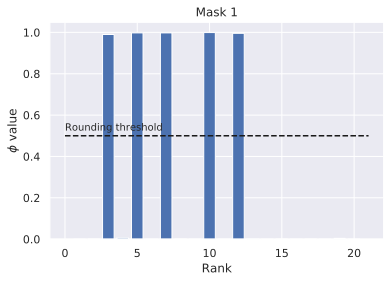

#nz ranks: 5/20


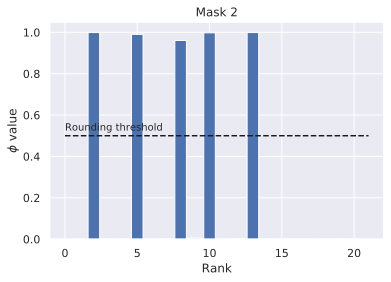

#nz ranks: 5/20


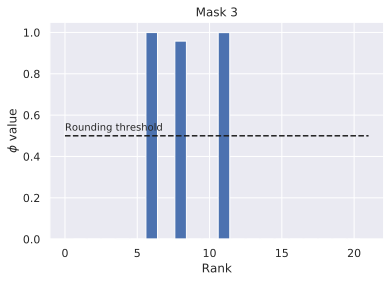

#nz ranks: 3/20

Compression:	388.889
Layer:  TT Linear with a TT-Matrix of size 625 x 10, underlying tensorshape: [25, 25] x [5, 2], TT-ranks: [1, 20, 1] 
 on device 'cuda:0' with compression rate 1.79


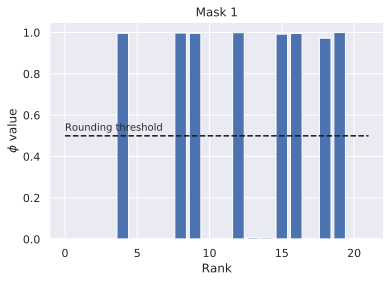

#nz ranks: 8/20

Compression:	4.464
Total compression:	150.800


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


Model number 2...

Layer:  TT Linear with a TT-Matrix of size 784 x 625, underlying tensorshape: [7, 4, 7, 4] x [5, 5, 5, 5], TT-ranks: [1, 20, 20, 20, 1] 
 on device 'cuda:0' with compression rate 21.21


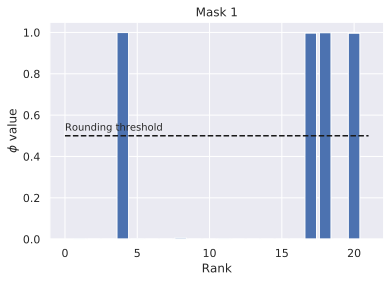

#nz ranks: 4/20


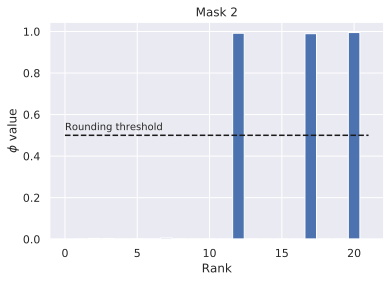

#nz ranks: 3/20


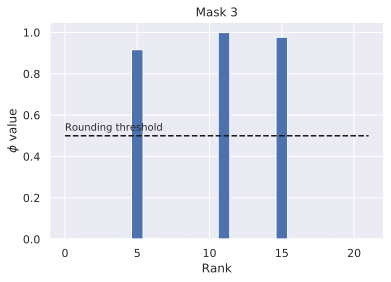

#nz ranks: 3/20

Compression:	649.007
Layer:  TT Linear with a TT-Matrix of size 625 x 10, underlying tensorshape: [25, 25] x [5, 2], TT-ranks: [1, 20, 1] 
 on device 'cuda:0' with compression rate 1.79


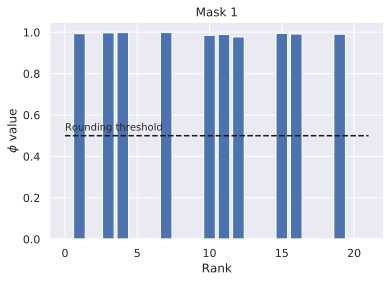

#nz ranks: 10/20

Compression:	3.571
Total compression:	158.244


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


Model number 3...

Layer:  TT Linear with a TT-Matrix of size 784 x 625, underlying tensorshape: [7, 4, 7, 4] x [5, 5, 5, 5], TT-ranks: [1, 20, 20, 20, 1] 
 on device 'cuda:0' with compression rate 21.21


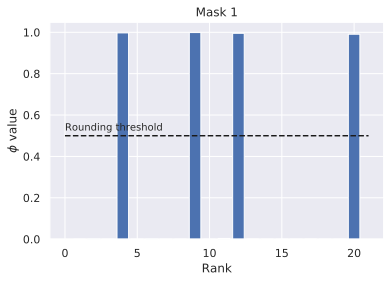

#nz ranks: 4/20


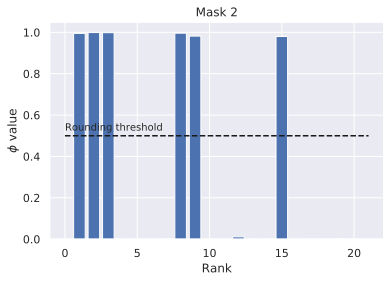

#nz ranks: 6/20


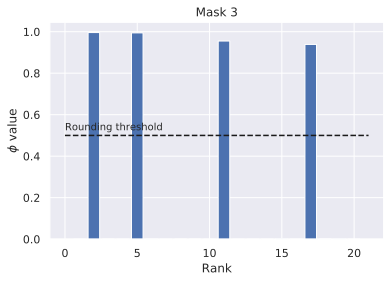

#nz ranks: 4/20

Compression:	318.182
Layer:  TT Linear with a TT-Matrix of size 625 x 10, underlying tensorshape: [25, 25] x [5, 2], TT-ranks: [1, 20, 1] 
 on device 'cuda:0' with compression rate 1.79


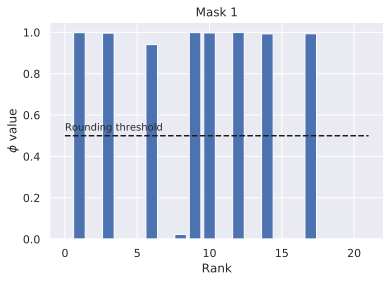

#nz ranks: 8/20

Compression:	4.464
Total compression:	138.989


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


Model number 4...

Layer:  TT Linear with a TT-Matrix of size 784 x 625, underlying tensorshape: [7, 4, 7, 4] x [5, 5, 5, 5], TT-ranks: [1, 20, 20, 20, 1] 
 on device 'cuda:0' with compression rate 21.21


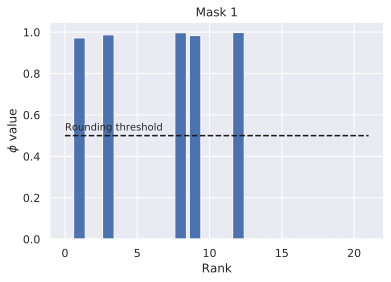

#nz ranks: 5/20


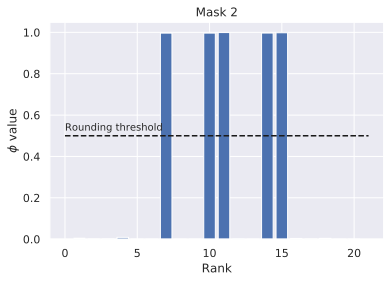

#nz ranks: 5/20


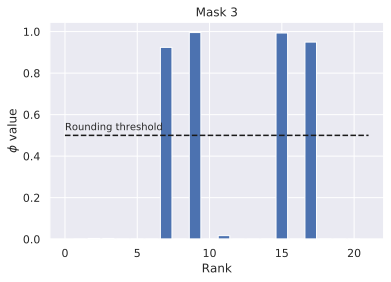

#nz ranks: 4/20

Compression:	336.770
Layer:  TT Linear with a TT-Matrix of size 625 x 10, underlying tensorshape: [25, 25] x [5, 2], TT-ranks: [1, 20, 1] 
 on device 'cuda:0' with compression rate 1.79


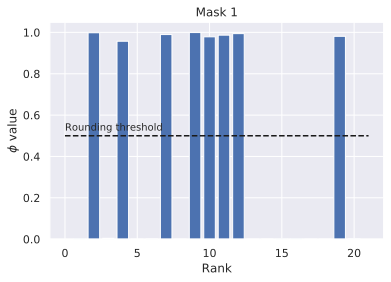

#nz ranks: 8/20

Compression:	4.464
Total compression:	142.374


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


Model number 5...

Layer:  TT Linear with a TT-Matrix of size 784 x 625, underlying tensorshape: [7, 4, 7, 4] x [5, 5, 5, 5], TT-ranks: [1, 20, 20, 20, 1] 
 on device 'cuda:0' with compression rate 21.21


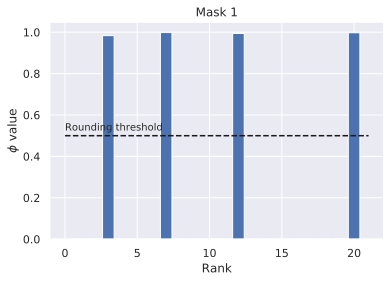

#nz ranks: 4/20


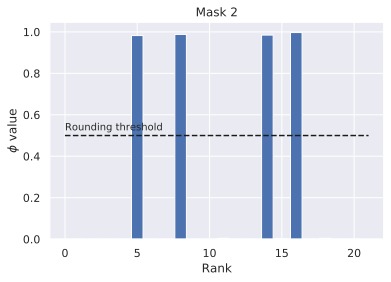

#nz ranks: 4/20


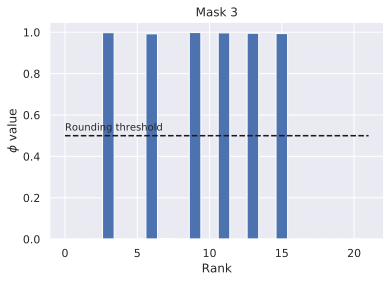

#nz ranks: 6/20

Compression:	345.070
Layer:  TT Linear with a TT-Matrix of size 625 x 10, underlying tensorshape: [25, 25] x [5, 2], TT-ranks: [1, 20, 1] 
 on device 'cuda:0' with compression rate 1.79


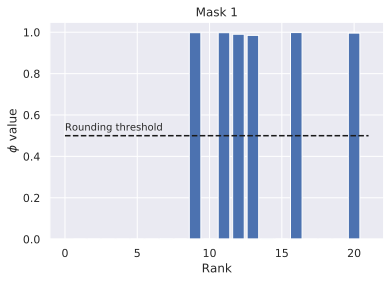

#nz ranks: 6/20

Compression:	5.952
Total compression:	160.027


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


Model number 6...

Layer:  TT Linear with a TT-Matrix of size 784 x 625, underlying tensorshape: [7, 4, 7, 4] x [5, 5, 5, 5], TT-ranks: [1, 20, 20, 20, 1] 
 on device 'cuda:0' with compression rate 21.21


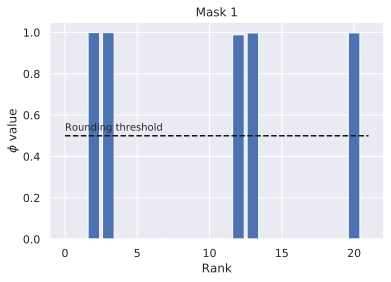

#nz ranks: 5/20


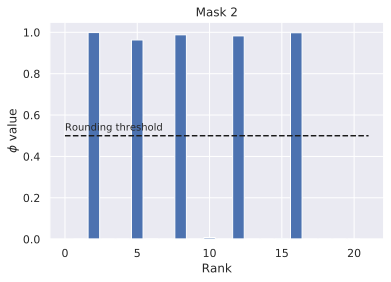

#nz ranks: 5/20


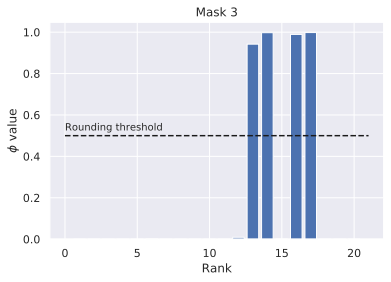

#nz ranks: 4/20

Compression:	336.770
Layer:  TT Linear with a TT-Matrix of size 625 x 10, underlying tensorshape: [25, 25] x [5, 2], TT-ranks: [1, 20, 1] 
 on device 'cuda:0' with compression rate 1.79


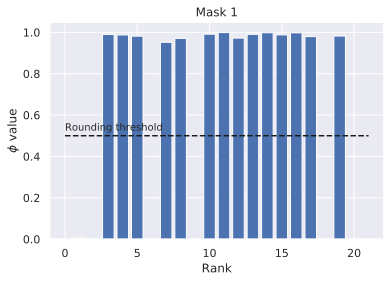

#nz ranks: 14/20

Compression:	2.551
Total compression:	109.446


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


Model number 7...

Layer:  TT Linear with a TT-Matrix of size 784 x 625, underlying tensorshape: [7, 4, 7, 4] x [5, 5, 5, 5], TT-ranks: [1, 20, 20, 20, 1] 
 on device 'cuda:0' with compression rate 21.21


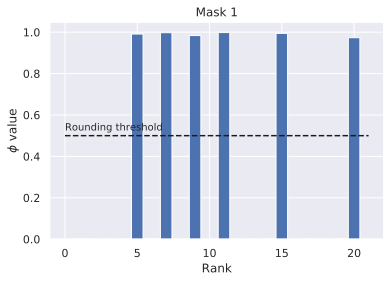

#nz ranks: 6/20


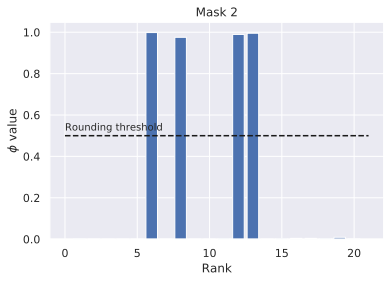

#nz ranks: 4/20


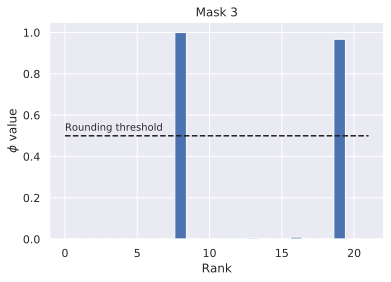

#nz ranks: 2/20

Compression:	485.149
Layer:  TT Linear with a TT-Matrix of size 625 x 10, underlying tensorshape: [25, 25] x [5, 2], TT-ranks: [1, 20, 1] 
 on device 'cuda:0' with compression rate 1.79


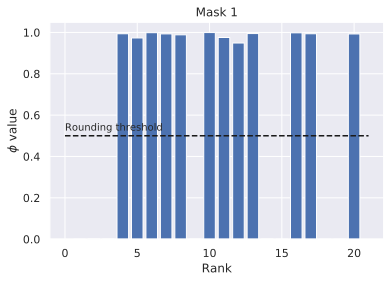

#nz ranks: 12/20

Compression:	2.976
Total compression:	132.680


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


Model number 8...

Layer:  TT Linear with a TT-Matrix of size 784 x 625, underlying tensorshape: [7, 4, 7, 4] x [5, 5, 5, 5], TT-ranks: [1, 20, 20, 20, 1] 
 on device 'cuda:0' with compression rate 21.21


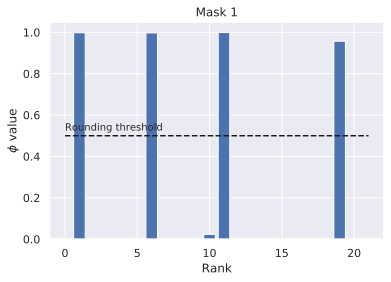

#nz ranks: 4/20


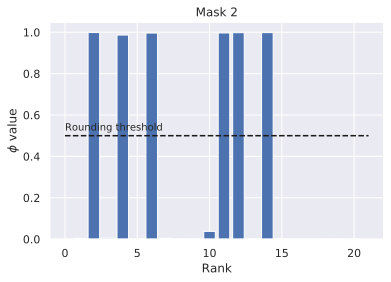

#nz ranks: 6/20


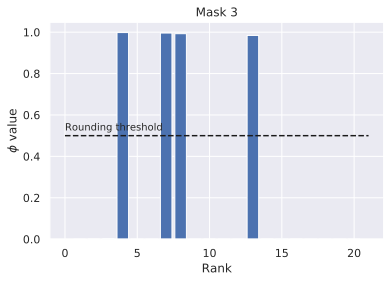

#nz ranks: 4/20

Compression:	318.182
Layer:  TT Linear with a TT-Matrix of size 625 x 10, underlying tensorshape: [25, 25] x [5, 2], TT-ranks: [1, 20, 1] 
 on device 'cuda:0' with compression rate 1.79


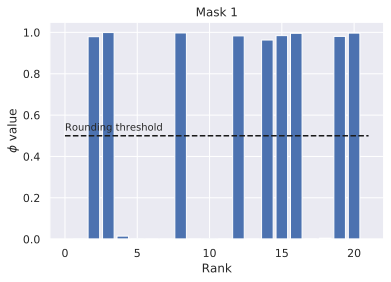

#nz ranks: 9/20

Compression:	3.968
Total compression:	132.503


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


Model number 9...

Layer:  TT Linear with a TT-Matrix of size 784 x 625, underlying tensorshape: [7, 4, 7, 4] x [5, 5, 5, 5], TT-ranks: [1, 20, 20, 20, 1] 
 on device 'cuda:0' with compression rate 21.21


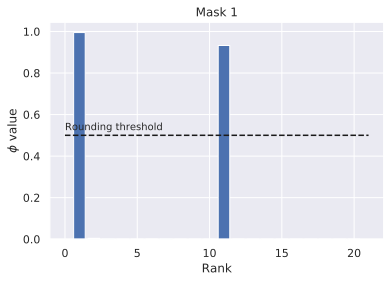

#nz ranks: 2/20


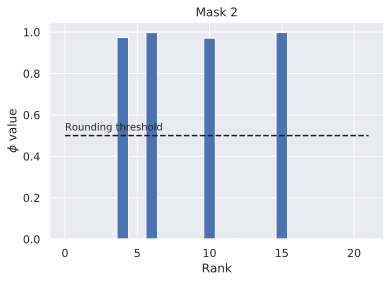

#nz ranks: 4/20


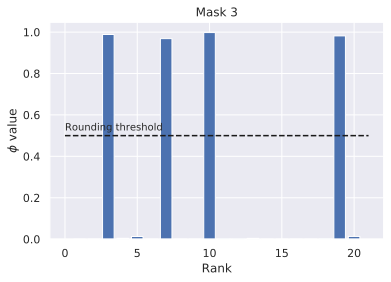

#nz ranks: 4/20

Compression:	563.218
Layer:  TT Linear with a TT-Matrix of size 625 x 10, underlying tensorshape: [25, 25] x [5, 2], TT-ranks: [1, 20, 1] 
 on device 'cuda:0' with compression rate 1.79


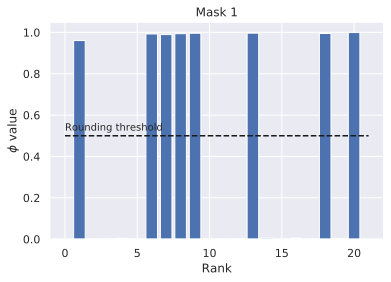

#nz ranks: 8/20

Compression:	4.464
Total compression:	171.045


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


Model number 10...

Layer:  TT Linear with a TT-Matrix of size 784 x 625, underlying tensorshape: [7, 4, 7, 4] x [5, 5, 5, 5], TT-ranks: [1, 20, 20, 20, 1] 
 on device 'cuda:0' with compression rate 21.21


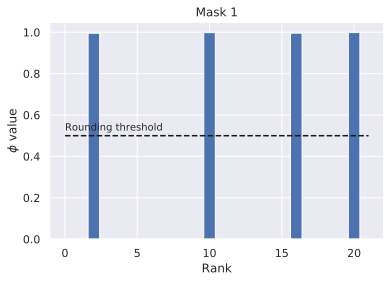

#nz ranks: 4/20


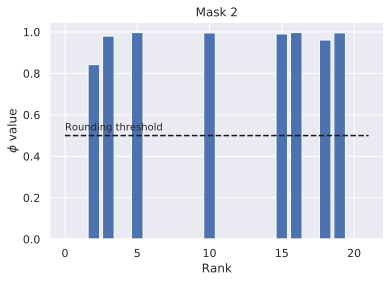

#nz ranks: 8/20


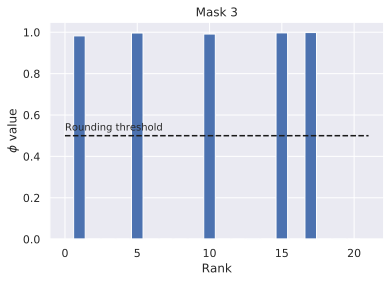

#nz ranks: 5/20

Compression:	214.912
Layer:  TT Linear with a TT-Matrix of size 625 x 10, underlying tensorshape: [25, 25] x [5, 2], TT-ranks: [1, 20, 1] 
 on device 'cuda:0' with compression rate 1.79


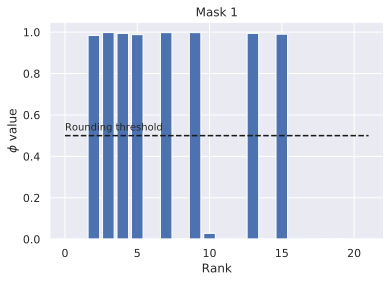

#nz ranks: 8/20

Compression:	4.464
Total compression:	115.153


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------




In [14]:
comps = []

for k, model in enumerate(models, 1):
    print(f"Model number {k}...")
    print()
    comps.append(get_comp_info(model))
    print()
    print()
    print(100*'-')
    print(100*'-')
    print(100*'-')
    print()
    print()

In [15]:
accuracies = dict()

accuracies["marginal"] = []
for k, model in enumerate(models, 1):
    k_acc = eval_model(model)
    print(f"Accuracy of model {k}:\t%.2f%%" % (100 * k_acc))
    accuracies["marginal"].append(k_acc)
    
print()

ensemble_acc = eval_ensemble(models)
print('Accuracy of the ensemble:\t%.2f%%' % (100 * ensemble_acc))
accuracies["ensemble"] = ensemble_acc

Accuracy of model 1:	98.01%
Accuracy of model 2:	98.09%
Accuracy of model 3:	98.30%
Accuracy of model 4:	98.29%
Accuracy of model 5:	98.08%
Accuracy of model 6:	98.23%
Accuracy of model 7:	98.24%
Accuracy of model 8:	98.02%
Accuracy of model 9:	98.00%
Accuracy of model 10:	98.16%

Accuracy of the ensemble:	98.91%


In [16]:
for k, comp in enumerate(comps, 1):
    print(f"Model {k} total compression:\t%.3f" % comp)

Model 1 total compression:	150.800
Model 2 total compression:	158.244
Model 3 total compression:	138.989
Model 4 total compression:	142.374
Model 5 total compression:	160.027
Model 6 total compression:	109.446
Model 7 total compression:	132.680
Model 8 total compression:	132.503
Model 9 total compression:	171.045
Model 10 total compression:	115.153
